# Credit Card Service Prediction Model

# Load Libraries

In [16]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import scipy.stats as stats 

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# to make this notebook's output identical at every run
np.random.seed(42)

# Function Definitions

In [2]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2 )
    return df

def draw_col_shape(df_feature,cols):
    # draw a bar graph with he number of members of a columns specify in field Cols
    
    # Dictionary for X Axis Labels
    dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
                 'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
                 'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
                 'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
                 'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
                 'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
                 'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 
                 'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
                 'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
                 'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',

                }


    # number of members per state

    for col in cols:
        counts = df_feature[col].value_counts()
        sns.set(style="whitegrid")
        plt.axhline(0, color="k", clip_on=False)
        plt.ylabel("# of Classes",fontsize=14, fontweight='bold')
        plt.xlabel("Classes", fontsize=14, fontweight='bold')
        plt.title('Total  Number of Classes',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        sns.barplot(counts.index, counts.values)
        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large')
        i = 0
        for v in list(counts.values):
            plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
            i +=1
        plt.show()
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        counts.reset_index(inplace=True)
        counts.rename(columns={"index": dict_cols[col], col: "# of Classes"}, inplace=True)
        fig = ff.create_table(counts, height_constant=30, index=False)
        py.iplot(fig)
        return

# Load data from consolidate file by household key and transacton file 

In [3]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_household = read_data('household_view.csv')
df_transaction = read_data('capstone_aaa_featured.csv')

# Model to predict Credit Card Service Usage by household key

In [4]:
cols_house_dummmies = ['income', 'tenure', 'credit_ranges','education', 'generation', 'cancel_reason',
                       'race', 'home_owner', 'dwelling_type', 'mosaic_global_household',
                       'plus_indicator_description', 'gender', 'mosaic_household',
                       'kcl_b_ind_mosaicsgrouping', 'sc_vehicle_manufacturer_name'
             ]
feature_cols = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                    'total_calls', 'total_member_cost', 'total_cost'
                   ]
var_to_predict = ['aaa_credit_card']

# Build Dummies Variables
df_dummies = pd.get_dummies(df_household, columns=cols_house_dummmies)
for i in cols_house_dummmies:
    cols = [j for j in df_dummies.columns if j.startswith(i)]
    feature_cols += cols

# construct Dataframe for prediction
feature_cols += var_to_predict
df_prediction = pd.DataFrame(df_dummies, columns=feature_cols)
df_prediction.head(5)

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost,"income_10-19,999","income_100-149,999","income_150 - 174,999","income_175 - 199,999","income_20-29,999","income_200 - 249,999",income_250K+,"income_30-39,999","income_40-49,999","income_50-59,999","income_60-69,999","income_70-79,999","income_80-89,999","income_90-99,999",income_UNDER 10K,income_UNKNOWN,tenure_+40 YEARS,tenure_< 1 YEAR,tenure_BETWEEN 1 & 5 YEARS,tenure_BETWEEN 11 & 15 YEARS,tenure_BETWEEN 16 & 20 YEARS,tenure_BETWEEN 21 & 30 YEARS,tenure_BETWEEN 31 & 40 YEARS,tenure_BETWEEN 6 & 10 YEARS,credit_ranges_499 & LESS,credit_ranges_500-549,credit_ranges_550-599,credit_ranges_600-649,credit_ranges_650-699,credit_ranges_700-749,credit_ranges_750-799,credit_ranges_800+,credit_ranges_UNKNOWN,education_COMPLETED COLLEGE,education_GRADUATED SCHOOL,education_HIGH SCHOOL,education_SOME COLLEGE,education_UNKNOWN,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),generation_UNKNOWN,...,kcl_b_ind_mosaicsgrouping_UNKNOWN,kcl_b_ind_mosaicsgrouping_YOUNG CITY SOLOS,sc_vehicle_manufacturer_name_ACURA,sc_vehicle_manufacturer_name_AUDI,sc_vehicle_manufacturer_name_BICYCLE,sc_vehicle_manufacturer_name_BMW,sc_vehicle_manufacturer_name_BUICK,sc_vehicle_manufacturer_name_CADILLAC,sc_vehicle_manufacturer_name_CHEVROLET,sc_vehicle_manufacturer_name_CHRYSLER,sc_vehicle_manufacturer_name_CRYSLER,sc_vehicle_manufacturer_name_DODGE,sc_vehicle_manufacturer_name_FIAT,sc_vehicle_manufacturer_name_FORD,sc_vehicle_manufacturer_name_GENESIS,sc_vehicle_manufacturer_name_GEO,sc_vehicle_manufacturer_name_GMC,sc_vehicle_manufacturer_name_HARLEY DAVIDSON,sc_vehicle_manufacturer_name_HONDA,sc_vehicle_manufacturer_name_HYUNDAI,sc_vehicle_manufacturer_name_INFINITI,sc_vehicle_manufacturer_name_ISUZU,sc_vehicle_manufacturer_name_JAGUAR,sc_vehicle_manufacturer_name_JEEP,sc_vehicle_manufacturer_name_KIA,sc_vehicle_manufacturer_name_LAND ROVER,sc_vehicle_manufacturer_name_LEXUS,sc_vehicle_manufacturer_name_LINCOLN,sc_vehicle_manufacturer_name_MAZDA,sc_vehicle_manufacturer_name_MERCEDES-BENZ,sc_vehicle_manufacturer_name_MERCURY,sc_vehicle_manufacturer_name_MG,sc_vehicle_manufacturer_name_MINI,sc_vehicle_manufacturer_name_MITSUBISHI,sc_vehicle_manufacturer_name_NISSAN,sc_vehicle_manufacturer_name_OLDSMOBILE,sc_vehicle_manufacturer_name_PLYMOUTH,sc_vehicle_manufacturer_name_PONTIAC,sc_vehicle_manufacturer_name_PORSCHE,sc_vehicle_manufacturer_name_RAM,sc_vehicle_manufacturer_name_SAAB,sc_vehicle_manufacturer_name_SATURN,sc_vehicle_manufacturer_name_SCION,sc_vehicle_manufacturer_name_SUBARU,sc_vehicle_manufacturer_name_SUZUKI,sc_vehicle_manufacturer_name_TOYOTA,sc_vehicle_manufacturer_name_UNKNOWN,sc_vehicle_manufacturer_name_VOLKSWAGEN,sc_vehicle_manufacturer_name_VOLVO,aaa_credit_card
0,50.1765,0.0000,nan,27.0000,2245.7800,1063.2000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,62.0000,4.6667,1.0000,13.0000,1256.4200,226.1000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,89.0000,1.6667,2.0000,0.0000,0.0000,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,67.0000,7.5000,1.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,62.5000,12.1429,2.1429,21.0000,1168.0500,294.2500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0

In [5]:
df_household.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 65 columns):
household_key                        5240 non-null int64
income                               5240 non-null object
member_status                        5240 non-null object
state_grouped                        5240 non-null object
credit_ranges                        5240 non-null object
cancel_reason                        5240 non-null object
renew_method                         5240 non-null object
plus_indicator_description           5240 non-null object
zip                                  5240 non-null int64
sc_vehicle_manufacturer_name         5240 non-null object
sc_vehicle_model_name                5240 non-null object
race                                 5240 non-null object
home_owner                           5240 non-null object
education                            5240 non-null object
dwelling_type                        5240 non-null object
gender                   

In [6]:
df_prediction.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 256 columns):
aaa_mean_age                                                           4963 non-null float64
length_of_residence                                                    5240 non-null float64
aaa_mean_child                                                         3612 non-null float64
total_calls                                                            5240 non-null float64
total_member_cost                                                      5240 non-null float64
total_cost                                                             5240 non-null float64
income_10-19,999                                                       5240 non-null uint8
income_100-149,999                                                     5240 non-null uint8
income_150 - 174,999                                                   5240 non-null uint8
income_175 - 199,999                                         

In [12]:
# Fix Nans
# Number of child
df_prediction.aaa_mean_child.fillna(value=0, inplace=True)
# Drop records with no age
df_prediction = df_prediction[~df_prediction.aaa_mean_age.isna()]
# Drop Unknown Columns 
cols_to_drop = [j for j in df_dummies.columns if j.endswith('UNKNOWN')]
df_prediction.drop(labels=cols_to_drop,axis=1, inplace=True)

# Save columns name for future use in modelling to split X-Input and y-Output
X_cols = df_prediction.columns[:-1]
y_cols = var_to_predict.copy()


In [13]:
df_prediction.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost,"income_10-19,999","income_100-149,999","income_150 - 174,999","income_175 - 199,999","income_20-29,999","income_200 - 249,999",income_250K+,"income_30-39,999","income_40-49,999","income_50-59,999","income_60-69,999","income_70-79,999","income_80-89,999","income_90-99,999",income_UNDER 10K,tenure_+40 YEARS,tenure_< 1 YEAR,tenure_BETWEEN 1 & 5 YEARS,tenure_BETWEEN 11 & 15 YEARS,tenure_BETWEEN 16 & 20 YEARS,tenure_BETWEEN 21 & 30 YEARS,tenure_BETWEEN 31 & 40 YEARS,tenure_BETWEEN 6 & 10 YEARS,credit_ranges_499 & LESS,credit_ranges_500-549,credit_ranges_550-599,credit_ranges_600-649,credit_ranges_650-699,credit_ranges_700-749,credit_ranges_750-799,credit_ranges_800+,education_COMPLETED COLLEGE,education_GRADUATED SCHOOL,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),cancel_reason_*BAD CHECKS*,cancel_reason_BAD ADD SET BY PO ACS,cancel_reason_CANCEL PROCESS - FUTURE CANCEL DNR,cancel_reason_CANCELLED DO NOT RENEW,...,kcl_b_ind_mosaicsgrouping_SURBURBAN STYLE,kcl_b_ind_mosaicsgrouping_THRIVING BOOMERS,kcl_b_ind_mosaicsgrouping_YOUNG CITY SOLOS,sc_vehicle_manufacturer_name_ACURA,sc_vehicle_manufacturer_name_AUDI,sc_vehicle_manufacturer_name_BICYCLE,sc_vehicle_manufacturer_name_BMW,sc_vehicle_manufacturer_name_BUICK,sc_vehicle_manufacturer_name_CADILLAC,sc_vehicle_manufacturer_name_CHEVROLET,sc_vehicle_manufacturer_name_CHRYSLER,sc_vehicle_manufacturer_name_CRYSLER,sc_vehicle_manufacturer_name_DODGE,sc_vehicle_manufacturer_name_FIAT,sc_vehicle_manufacturer_name_FORD,sc_vehicle_manufacturer_name_GENESIS,sc_vehicle_manufacturer_name_GEO,sc_vehicle_manufacturer_name_GMC,sc_vehicle_manufacturer_name_HARLEY DAVIDSON,sc_vehicle_manufacturer_name_HONDA,sc_vehicle_manufacturer_name_HYUNDAI,sc_vehicle_manufacturer_name_INFINITI,sc_vehicle_manufacturer_name_ISUZU,sc_vehicle_manufacturer_name_JAGUAR,sc_vehicle_manufacturer_name_JEEP,sc_vehicle_manufacturer_name_KIA,sc_vehicle_manufacturer_name_LAND ROVER,sc_vehicle_manufacturer_name_LEXUS,sc_vehicle_manufacturer_name_LINCOLN,sc_vehicle_manufacturer_name_MAZDA,sc_vehicle_manufacturer_name_MERCEDES-BENZ,sc_vehicle_manufacturer_name_MERCURY,sc_vehicle_manufacturer_name_MG,sc_vehicle_manufacturer_name_MINI,sc_vehicle_manufacturer_name_MITSUBISHI,sc_vehicle_manufacturer_name_NISSAN,sc_vehicle_manufacturer_name_OLDSMOBILE,sc_vehicle_manufacturer_name_PLYMOUTH,sc_vehicle_manufacturer_name_PONTIAC,sc_vehicle_manufacturer_name_PORSCHE,sc_vehicle_manufacturer_name_RAM,sc_vehicle_manufacturer_name_SAAB,sc_vehicle_manufacturer_name_SATURN,sc_vehicle_manufacturer_name_SCION,sc_vehicle_manufacturer_name_SUBARU,sc_vehicle_manufacturer_name_SUZUKI,sc_vehicle_manufacturer_name_TOYOTA,sc_vehicle_manufacturer_name_VOLKSWAGEN,sc_vehicle_manufacturer_name_VOLVO,aaa_credit_card
count,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,...,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0000,4963.0

In [14]:
#  Correlation of AAA Mortage Service 
df_prediction.corr()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost,"income_10-19,999","income_100-149,999","income_150 - 174,999","income_175 - 199,999","income_20-29,999","income_200 - 249,999",income_250K+,"income_30-39,999","income_40-49,999","income_50-59,999","income_60-69,999","income_70-79,999","income_80-89,999","income_90-99,999",income_UNDER 10K,tenure_+40 YEARS,tenure_< 1 YEAR,tenure_BETWEEN 1 & 5 YEARS,tenure_BETWEEN 11 & 15 YEARS,tenure_BETWEEN 16 & 20 YEARS,tenure_BETWEEN 21 & 30 YEARS,tenure_BETWEEN 31 & 40 YEARS,tenure_BETWEEN 6 & 10 YEARS,credit_ranges_499 & LESS,credit_ranges_500-549,credit_ranges_550-599,credit_ranges_600-649,credit_ranges_650-699,credit_ranges_700-749,credit_ranges_750-799,credit_ranges_800+,education_COMPLETED COLLEGE,education_GRADUATED SCHOOL,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),cancel_reason_*BAD CHECKS*,cancel_reason_BAD ADD SET BY PO ACS,cancel_reason_CANCEL PROCESS - FUTURE CANCEL DNR,cancel_reason_CANCELLED DO NOT RENEW,...,kcl_b_ind_mosaicsgrouping_SURBURBAN STYLE,kcl_b_ind_mosaicsgrouping_THRIVING BOOMERS,kcl_b_ind_mosaicsgrouping_YOUNG CITY SOLOS,sc_vehicle_manufacturer_name_ACURA,sc_vehicle_manufacturer_name_AUDI,sc_vehicle_manufacturer_name_BICYCLE,sc_vehicle_manufacturer_name_BMW,sc_vehicle_manufacturer_name_BUICK,sc_vehicle_manufacturer_name_CADILLAC,sc_vehicle_manufacturer_name_CHEVROLET,sc_vehicle_manufacturer_name_CHRYSLER,sc_vehicle_manufacturer_name_CRYSLER,sc_vehicle_manufacturer_name_DODGE,sc_vehicle_manufacturer_name_FIAT,sc_vehicle_manufacturer_name_FORD,sc_vehicle_manufacturer_name_GENESIS,sc_vehicle_manufacturer_name_GEO,sc_vehicle_manufacturer_name_GMC,sc_vehicle_manufacturer_name_HARLEY DAVIDSON,sc_vehicle_manufacturer_name_HONDA,sc_vehicle_manufacturer_name_HYUNDAI,sc_vehicle_manufacturer_name_INFINITI,sc_vehicle_manufacturer_name_ISUZU,sc_vehicle_manufacturer_name_JAGUAR,sc_vehicle_manufacturer_name_JEEP,sc_vehicle_manufacturer_name_KIA,sc_vehicle_manufacturer_name_LAND ROVER,sc_vehicle_manufacturer_name_LEXUS,sc_vehicle_manufacturer_name_LINCOLN,sc_vehicle_manufacturer_name_MAZDA,sc_vehicle_manufacturer_name_MERCEDES-BENZ,sc_vehicle_manufacturer_name_MERCURY,sc_vehicle_manufacturer_name_MG,sc_vehicle_manufacturer_name_MINI,sc_vehicle_manufacturer_name_MITSUBISHI,sc_vehicle_manufacturer_name_NISSAN,sc_vehicle_manufacturer_name_OLDSMOBILE,sc_vehicle_manufacturer_name_PLYMOUTH,sc_vehicle_manufacturer_name_PONTIAC,sc_vehicle_manufacturer_name_PORSCHE,sc_vehicle_manufacturer_name_RAM,sc_vehicle_manufacturer_name_SAAB,sc_vehicle_manufacturer_name_SATURN,sc_vehicle_manufacturer_name_SCION,sc_vehicle_manufacturer_name_SUBARU,sc_vehicle_manufacturer_name_SUZUKI,sc_vehicle_manufacturer_name_TOYOTA,sc_vehicle_manufacturer_name_VOLKSWAGEN,sc_vehicle_manufacturer_name_VOLVO,aaa_credit_card
aaa_mean_age,1.0000,-0.1305,-0.3880,-0.2199,-0.2186,-0.2574,0.0653,-0.1397,-0.0590,-0.0938,0.0158,-0.0897,-0.0706,0.0070,0.0192,0.0118,-0.0165,-0.0040,-0.0068,-0.1049,0.0224,0.1482,-0.0256,-0.1030,-0.0398,-0.0627,-0.0395,-0.0565,-0.0226,0.0024,-0.0095,0.0176,-0.0177,-0.0453,-0.0621,-0.1226,-0.0434,-0.0918,-0.0402,-0.0569,-0.0917,-0.4694,-0.2184,-0.1007,-0.2212,0.5812,-0.0227,-0.0096,nan,0.0163,...,-0.0829,-0.0521,-0.0097,-0.0294,-0.0357,-0.0033,-0.0417,0.0360,-0.0183,-0.0330,0.0088,-0.0258,-0.0385,-0.0019,-0.0585,-0.0244,0.0220,-0.0533,-0.0081,-0.0283,-0.0447,-0.0188,-0.0096,-0.0125,-0.0560,-0.0032,-0.0086,-0.0011,0.0212,-0.0188,-0.0338,0.0266,0.0112,0.0088,-0.0004,-0.0694,0.0425,0.0046,-0.0027,-0.0258,-0.0204,-0.0063,0.0004,-0.0171,-0.0425,-0.0033,0.0208,-0.0491,-0.0199,-0.0668
length_of_residence,-0.1305,1.0000,0.4337,0.0552,0.0566,0.0781,0.0736,0.2169,0.0969,0.0910,0.0972,0.0634,0.0621,0.0964,0.0882,0.1349,0.0782,0.1407,-0.0107,0.1858,0.0435,0.1161,0.0030,-0.0525,-0.0643,-0.0330

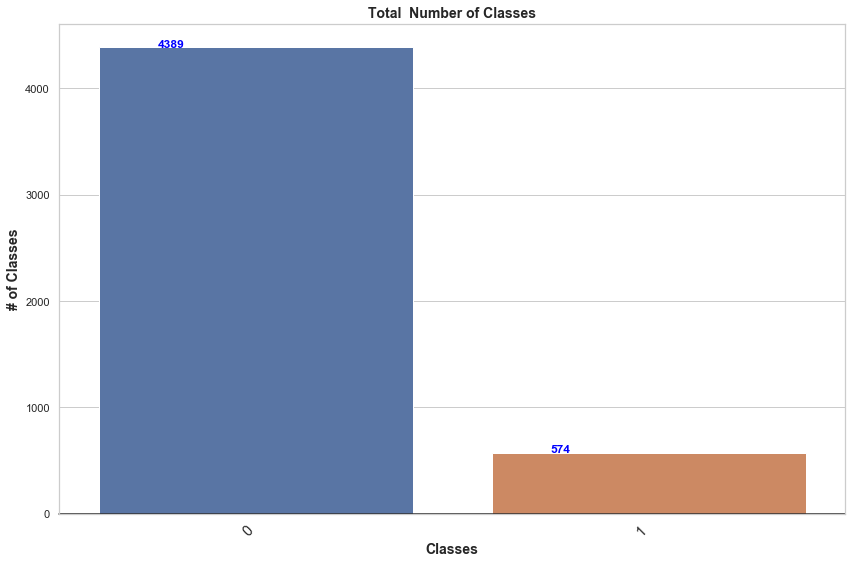

In [17]:
draw_col_shape(df_prediction,var_to_predict)

Random over-sampling:
1    4389
0    4389
Name: aaa_credit_card, dtype: int64


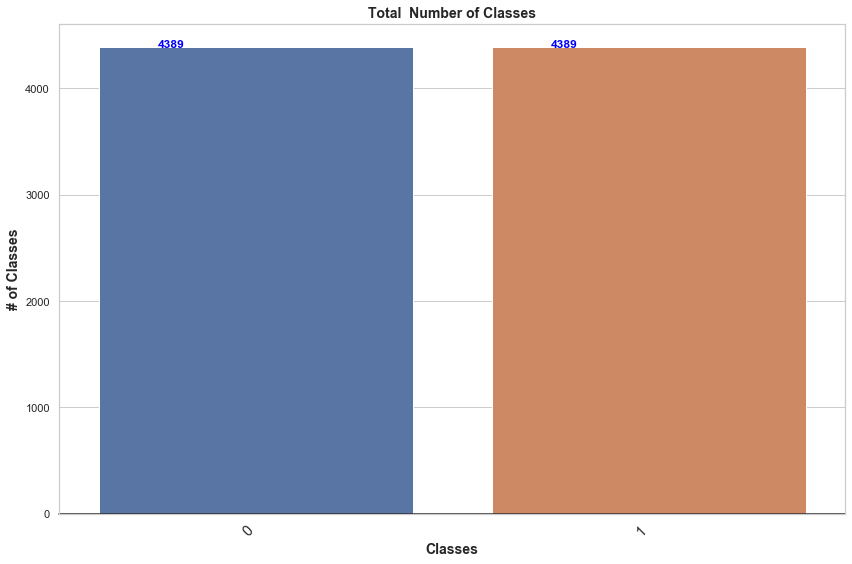

In [18]:
# Balance class Up Sampling
# As there is only 11 members that are using the mortgage service.
# Will upsample the 11 (yes) to 4952
# Evaluate imbalanced classification model with different metrics

# Class count
count_class_0, count_class_1 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over[var_to_predict[0]].value_counts())

draw_col_shape(df_test_over,var_to_predict)
plt.show()

In [19]:
df_test_over.corr()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost,"income_10-19,999","income_100-149,999","income_150 - 174,999","income_175 - 199,999","income_20-29,999","income_200 - 249,999",income_250K+,"income_30-39,999","income_40-49,999","income_50-59,999","income_60-69,999","income_70-79,999","income_80-89,999","income_90-99,999",income_UNDER 10K,tenure_+40 YEARS,tenure_< 1 YEAR,tenure_BETWEEN 1 & 5 YEARS,tenure_BETWEEN 11 & 15 YEARS,tenure_BETWEEN 16 & 20 YEARS,tenure_BETWEEN 21 & 30 YEARS,tenure_BETWEEN 31 & 40 YEARS,tenure_BETWEEN 6 & 10 YEARS,credit_ranges_499 & LESS,credit_ranges_500-549,credit_ranges_550-599,credit_ranges_600-649,credit_ranges_650-699,credit_ranges_700-749,credit_ranges_750-799,credit_ranges_800+,education_COMPLETED COLLEGE,education_GRADUATED SCHOOL,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),cancel_reason_*BAD CHECKS*,cancel_reason_BAD ADD SET BY PO ACS,cancel_reason_CANCEL PROCESS - FUTURE CANCEL DNR,cancel_reason_CANCELLED DO NOT RENEW,...,kcl_b_ind_mosaicsgrouping_SURBURBAN STYLE,kcl_b_ind_mosaicsgrouping_THRIVING BOOMERS,kcl_b_ind_mosaicsgrouping_YOUNG CITY SOLOS,sc_vehicle_manufacturer_name_ACURA,sc_vehicle_manufacturer_name_AUDI,sc_vehicle_manufacturer_name_BICYCLE,sc_vehicle_manufacturer_name_BMW,sc_vehicle_manufacturer_name_BUICK,sc_vehicle_manufacturer_name_CADILLAC,sc_vehicle_manufacturer_name_CHEVROLET,sc_vehicle_manufacturer_name_CHRYSLER,sc_vehicle_manufacturer_name_CRYSLER,sc_vehicle_manufacturer_name_DODGE,sc_vehicle_manufacturer_name_FIAT,sc_vehicle_manufacturer_name_FORD,sc_vehicle_manufacturer_name_GENESIS,sc_vehicle_manufacturer_name_GEO,sc_vehicle_manufacturer_name_GMC,sc_vehicle_manufacturer_name_HARLEY DAVIDSON,sc_vehicle_manufacturer_name_HONDA,sc_vehicle_manufacturer_name_HYUNDAI,sc_vehicle_manufacturer_name_INFINITI,sc_vehicle_manufacturer_name_ISUZU,sc_vehicle_manufacturer_name_JAGUAR,sc_vehicle_manufacturer_name_JEEP,sc_vehicle_manufacturer_name_KIA,sc_vehicle_manufacturer_name_LAND ROVER,sc_vehicle_manufacturer_name_LEXUS,sc_vehicle_manufacturer_name_LINCOLN,sc_vehicle_manufacturer_name_MAZDA,sc_vehicle_manufacturer_name_MERCEDES-BENZ,sc_vehicle_manufacturer_name_MERCURY,sc_vehicle_manufacturer_name_MG,sc_vehicle_manufacturer_name_MINI,sc_vehicle_manufacturer_name_MITSUBISHI,sc_vehicle_manufacturer_name_NISSAN,sc_vehicle_manufacturer_name_OLDSMOBILE,sc_vehicle_manufacturer_name_PLYMOUTH,sc_vehicle_manufacturer_name_PONTIAC,sc_vehicle_manufacturer_name_PORSCHE,sc_vehicle_manufacturer_name_RAM,sc_vehicle_manufacturer_name_SAAB,sc_vehicle_manufacturer_name_SATURN,sc_vehicle_manufacturer_name_SCION,sc_vehicle_manufacturer_name_SUBARU,sc_vehicle_manufacturer_name_SUZUKI,sc_vehicle_manufacturer_name_TOYOTA,sc_vehicle_manufacturer_name_VOLKSWAGEN,sc_vehicle_manufacturer_name_VOLVO,aaa_credit_card
aaa_mean_age,1.0000,-0.0825,-0.3705,-0.2014,-0.2005,-0.2685,0.0339,-0.1344,-0.0834,-0.0721,0.0473,-0.0763,-0.0574,0.0154,0.0299,0.0286,0.0384,0.0075,-0.0040,-0.1065,0.0201,0.0985,-0.0169,-0.0806,-0.0248,-0.0301,-0.0288,-0.0473,-0.0097,0.0036,0.0195,0.0121,-0.0124,-0.0291,-0.0326,-0.1276,-0.0247,-0.0656,-0.0377,-0.0496,-0.0874,-0.4853,-0.1729,-0.0894,-0.1665,0.5707,-0.0169,-0.0066,nan,0.0182,...,-0.0938,-0.0479,0.0032,-0.0447,-0.0243,-0.0013,-0.0273,0.0304,-0.0008,-0.0296,-0.0144,-0.0192,-0.0160,-0.0006,-0.0160,-0.0182,0.0373,-0.0653,-0.0055,-0.0490,-0.0457,-0.0113,-0.0066,-0.0082,-0.0593,0.0250,-0.0016,0.0212,0.0251,-0.0074,-0.0169,0.0435,0.0096,0.0087,0.0095,-0.0516,0.0711,-0.0392,0.0190,-0.0186,-0.0140,-0.0011,0.0180,-0.0242,-0.0586,-0.0008,0.0259,-0.0346,0.0050,-0.1073
length_of_residence,-0.0825,1.0000,0.3863,-0.0012,0.0072,0.0354,0.0329,0.2060,0.0923,0.0866,0.0664,0.0401,0.0348,0.0747,0.0779,0.1508,0.0910,0.1265,-0.0100,0.1665,0.0281,0.1076,-0.0018,-0.0444,-0.0680,-0.0267,-0.0

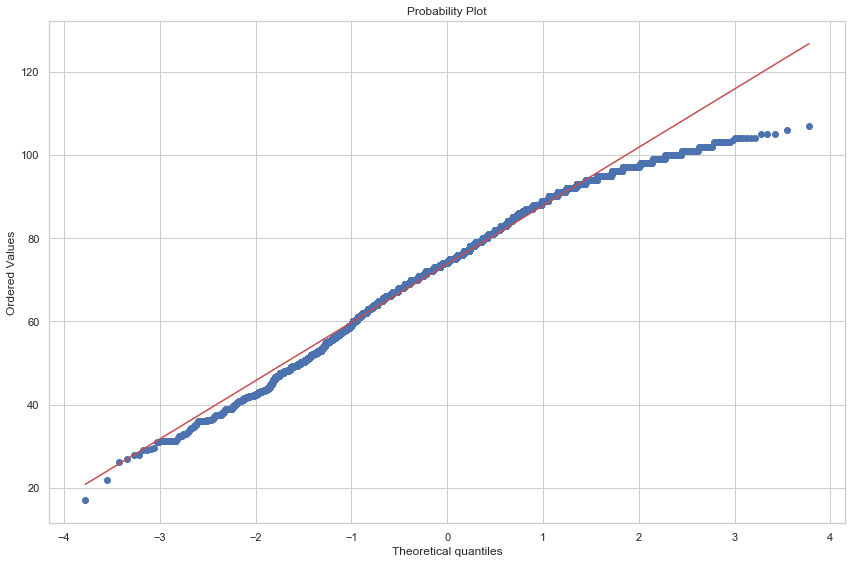

In [20]:
# Check probability plot of Mean Age Feature
stats.probplot(df_test_over.aaa_mean_age, dist="norm", plot=plt)
plt.show()

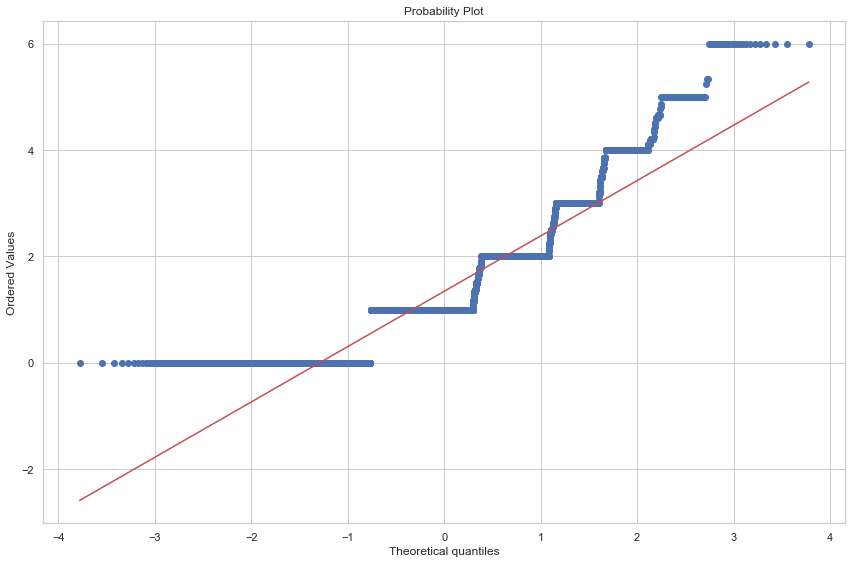

In [21]:
# Check probability plot of Number of Child
stats.probplot(df_test_over.aaa_mean_child, dist="norm", plot=plt)
plt.show()

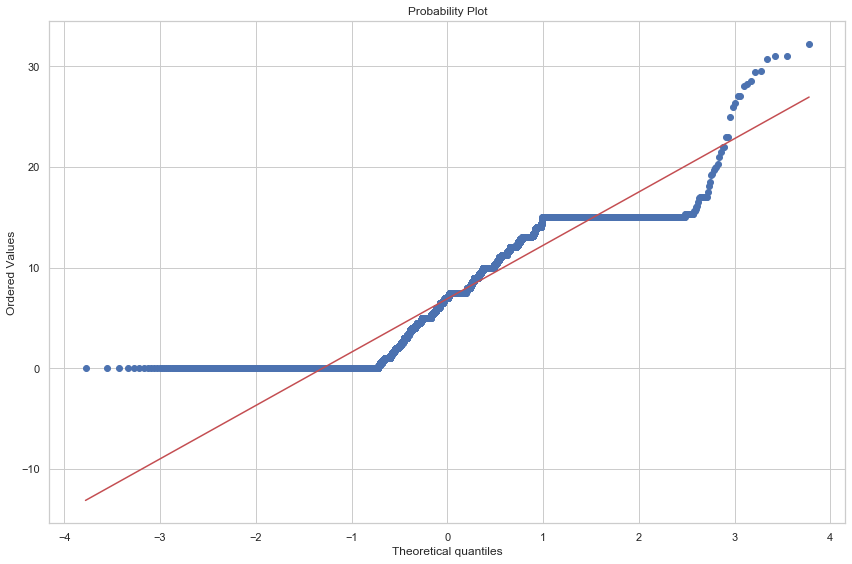

In [22]:
# Check probability plot of Length of residence
stats.probplot(df_test_over.length_of_residence, dist="norm", plot=plt)
plt.show()

In [23]:
df_test_over.head()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost,"income_10-19,999","income_100-149,999","income_150 - 174,999","income_175 - 199,999","income_20-29,999","income_200 - 249,999",income_250K+,"income_30-39,999","income_40-49,999","income_50-59,999","income_60-69,999","income_70-79,999","income_80-89,999","income_90-99,999",income_UNDER 10K,tenure_+40 YEARS,tenure_< 1 YEAR,tenure_BETWEEN 1 & 5 YEARS,tenure_BETWEEN 11 & 15 YEARS,tenure_BETWEEN 16 & 20 YEARS,tenure_BETWEEN 21 & 30 YEARS,tenure_BETWEEN 31 & 40 YEARS,tenure_BETWEEN 6 & 10 YEARS,credit_ranges_499 & LESS,credit_ranges_500-549,credit_ranges_550-599,credit_ranges_600-649,credit_ranges_650-699,credit_ranges_700-749,credit_ranges_750-799,credit_ranges_800+,education_COMPLETED COLLEGE,education_GRADUATED SCHOOL,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),cancel_reason_*BAD CHECKS*,cancel_reason_BAD ADD SET BY PO ACS,cancel_reason_CANCEL PROCESS - FUTURE CANCEL DNR,cancel_reason_CANCELLED DO NOT RENEW,...,kcl_b_ind_mosaicsgrouping_SURBURBAN STYLE,kcl_b_ind_mosaicsgrouping_THRIVING BOOMERS,kcl_b_ind_mosaicsgrouping_YOUNG CITY SOLOS,sc_vehicle_manufacturer_name_ACURA,sc_vehicle_manufacturer_name_AUDI,sc_vehicle_manufacturer_name_BICYCLE,sc_vehicle_manufacturer_name_BMW,sc_vehicle_manufacturer_name_BUICK,sc_vehicle_manufacturer_name_CADILLAC,sc_vehicle_manufacturer_name_CHEVROLET,sc_vehicle_manufacturer_name_CHRYSLER,sc_vehicle_manufacturer_name_CRYSLER,sc_vehicle_manufacturer_name_DODGE,sc_vehicle_manufacturer_name_FIAT,sc_vehicle_manufacturer_name_FORD,sc_vehicle_manufacturer_name_GENESIS,sc_vehicle_manufacturer_name_GEO,sc_vehicle_manufacturer_name_GMC,sc_vehicle_manufacturer_name_HARLEY DAVIDSON,sc_vehicle_manufacturer_name_HONDA,sc_vehicle_manufacturer_name_HYUNDAI,sc_vehicle_manufacturer_name_INFINITI,sc_vehicle_manufacturer_name_ISUZU,sc_vehicle_manufacturer_name_JAGUAR,sc_vehicle_manufacturer_name_JEEP,sc_vehicle_manufacturer_name_KIA,sc_vehicle_manufacturer_name_LAND ROVER,sc_vehicle_manufacturer_name_LEXUS,sc_vehicle_manufacturer_name_LINCOLN,sc_vehicle_manufacturer_name_MAZDA,sc_vehicle_manufacturer_name_MERCEDES-BENZ,sc_vehicle_manufacturer_name_MERCURY,sc_vehicle_manufacturer_name_MG,sc_vehicle_manufacturer_name_MINI,sc_vehicle_manufacturer_name_MITSUBISHI,sc_vehicle_manufacturer_name_NISSAN,sc_vehicle_manufacturer_name_OLDSMOBILE,sc_vehicle_manufacturer_name_PLYMOUTH,sc_vehicle_manufacturer_name_PONTIAC,sc_vehicle_manufacturer_name_PORSCHE,sc_vehicle_manufacturer_name_RAM,sc_vehicle_manufacturer_name_SAAB,sc_vehicle_manufacturer_name_SATURN,sc_vehicle_manufacturer_name_SCION,sc_vehicle_manufacturer_name_SUBARU,sc_vehicle_manufacturer_name_SUZUKI,sc_vehicle_manufacturer_name_TOYOTA,sc_vehicle_manufacturer_name_VOLKSWAGEN,sc_vehicle_manufacturer_name_VOLVO,aaa_credit_card
1,62.0000,4.6667,1.0000,13.0000,1256.4200,226.1000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,89.0000,1.6667,2.0000,0.0000,0.0000,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,67.0000,7.5000,1.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,62.5000,12.1429,2.1429,21.0000,1168.0500,294.2500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,63.2500,11.2500,1.0000,1.0000,58.

In [24]:
df_test_over.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost,"income_10-19,999","income_100-149,999","income_150 - 174,999","income_175 - 199,999","income_20-29,999","income_200 - 249,999",income_250K+,"income_30-39,999","income_40-49,999","income_50-59,999","income_60-69,999","income_70-79,999","income_80-89,999","income_90-99,999",income_UNDER 10K,tenure_+40 YEARS,tenure_< 1 YEAR,tenure_BETWEEN 1 & 5 YEARS,tenure_BETWEEN 11 & 15 YEARS,tenure_BETWEEN 16 & 20 YEARS,tenure_BETWEEN 21 & 30 YEARS,tenure_BETWEEN 31 & 40 YEARS,tenure_BETWEEN 6 & 10 YEARS,credit_ranges_499 & LESS,credit_ranges_500-549,credit_ranges_550-599,credit_ranges_600-649,credit_ranges_650-699,credit_ranges_700-749,credit_ranges_750-799,credit_ranges_800+,education_COMPLETED COLLEGE,education_GRADUATED SCHOOL,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),cancel_reason_*BAD CHECKS*,cancel_reason_BAD ADD SET BY PO ACS,cancel_reason_CANCEL PROCESS - FUTURE CANCEL DNR,cancel_reason_CANCELLED DO NOT RENEW,...,kcl_b_ind_mosaicsgrouping_SURBURBAN STYLE,kcl_b_ind_mosaicsgrouping_THRIVING BOOMERS,kcl_b_ind_mosaicsgrouping_YOUNG CITY SOLOS,sc_vehicle_manufacturer_name_ACURA,sc_vehicle_manufacturer_name_AUDI,sc_vehicle_manufacturer_name_BICYCLE,sc_vehicle_manufacturer_name_BMW,sc_vehicle_manufacturer_name_BUICK,sc_vehicle_manufacturer_name_CADILLAC,sc_vehicle_manufacturer_name_CHEVROLET,sc_vehicle_manufacturer_name_CHRYSLER,sc_vehicle_manufacturer_name_CRYSLER,sc_vehicle_manufacturer_name_DODGE,sc_vehicle_manufacturer_name_FIAT,sc_vehicle_manufacturer_name_FORD,sc_vehicle_manufacturer_name_GENESIS,sc_vehicle_manufacturer_name_GEO,sc_vehicle_manufacturer_name_GMC,sc_vehicle_manufacturer_name_HARLEY DAVIDSON,sc_vehicle_manufacturer_name_HONDA,sc_vehicle_manufacturer_name_HYUNDAI,sc_vehicle_manufacturer_name_INFINITI,sc_vehicle_manufacturer_name_ISUZU,sc_vehicle_manufacturer_name_JAGUAR,sc_vehicle_manufacturer_name_JEEP,sc_vehicle_manufacturer_name_KIA,sc_vehicle_manufacturer_name_LAND ROVER,sc_vehicle_manufacturer_name_LEXUS,sc_vehicle_manufacturer_name_LINCOLN,sc_vehicle_manufacturer_name_MAZDA,sc_vehicle_manufacturer_name_MERCEDES-BENZ,sc_vehicle_manufacturer_name_MERCURY,sc_vehicle_manufacturer_name_MG,sc_vehicle_manufacturer_name_MINI,sc_vehicle_manufacturer_name_MITSUBISHI,sc_vehicle_manufacturer_name_NISSAN,sc_vehicle_manufacturer_name_OLDSMOBILE,sc_vehicle_manufacturer_name_PLYMOUTH,sc_vehicle_manufacturer_name_PONTIAC,sc_vehicle_manufacturer_name_PORSCHE,sc_vehicle_manufacturer_name_RAM,sc_vehicle_manufacturer_name_SAAB,sc_vehicle_manufacturer_name_SATURN,sc_vehicle_manufacturer_name_SCION,sc_vehicle_manufacturer_name_SUBARU,sc_vehicle_manufacturer_name_SUZUKI,sc_vehicle_manufacturer_name_TOYOTA,sc_vehicle_manufacturer_name_VOLKSWAGEN,sc_vehicle_manufacturer_name_VOLVO,aaa_credit_card
count,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,...,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0

In [25]:
df_test_over.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8778 entries, 1 to 2598
Data columns (total 240 columns):
aaa_mean_age                                                           8778 non-null float64
length_of_residence                                                    8778 non-null float64
aaa_mean_child                                                         8778 non-null float64
total_calls                                                            8778 non-null float64
total_member_cost                                                      8778 non-null float64
total_cost                                                             8778 non-null float64
income_10-19,999                                                       8778 non-null uint8
income_100-149,999                                                     8778 non-null uint8
income_150 - 174,999                                                   8778 non-null uint8
income_175 - 199,999                                         

# Grid Search Logistic Regression

In [32]:
# Grid Search
# Logistic regression
np.random.seed(42)

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(X_df, y_df, test_size=0.50)


logregpipe = Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                   ('logreg',LogisticRegression(penalty='l1',multi_class="auto",solver="liblinear"))])

# Grid search to determine the value of C
param_grid = {'logreg__C':np.arange(0.01,100,10)}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=5,return_train_score=True, scoring='accuracy')
logreg_cv.fit(trainX, trainy)
print('Best C Parameter : ', logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(trainX,trainy)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
print('Accuracy Training Data : %.3f' % bestlogreg.score(trainX,trainy))

Best C Parameter :  {'logreg__C': 90.01}
Accuracy Training Data : 0.678


Accuracy                   : 0.643
Precision                  : 0.627
Recall                     : 0.705
F-measure                  : 0.664
Log-Loss                   : 12.324
No Skill - ROC AUC         : 0.500
Logistic - ROC AUC         : 0.703
Cross Validation Accuracy  : 0.648 (+/- 0.019)


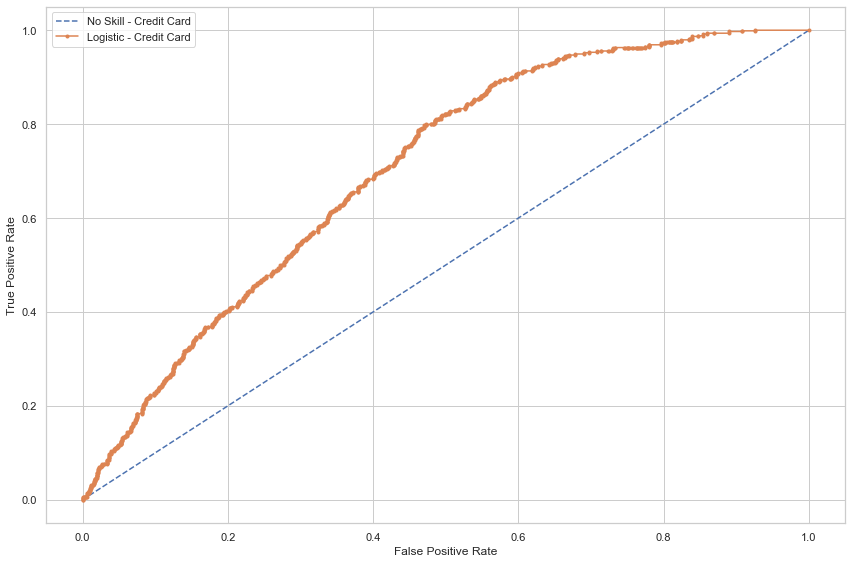

In [66]:
# Use Logistic Regression algorithms to classify which customers are going to use credit card services or not (0 = No, 1 = Yes)
# Using Oversample Dataframe with transformation MinMax Scaler

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

# Define model 
model = LogisticRegression(penalty='l2',multi_class="auto", solver="liblinear", C=90)

# Fit model
model.fit(trainX, trainy)

# Predict on test set
yhat = model.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = model.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
scores = cross_val_score(model, testX, testy, cv=5)

# Evaluate predictions
print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Precision                  : %.3f' % precision_score(testy, yhat))
print('Recall                     : %.3f' % recall_score(testy, yhat))
print('F-measure                  : %.3f' % f1_score(testy, yhat))
print('Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic - ROC AUC         : %.3f' % (lr_auc))
print("Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - Credit Card')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - Credit Card')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Confusion matrix - Credit Card, without normalization
[[1301  898]
 [ 659 1531]]
Normalized confusion matrix - Credit Card
[[0.59 0.41]
 [0.3  0.7 ]]


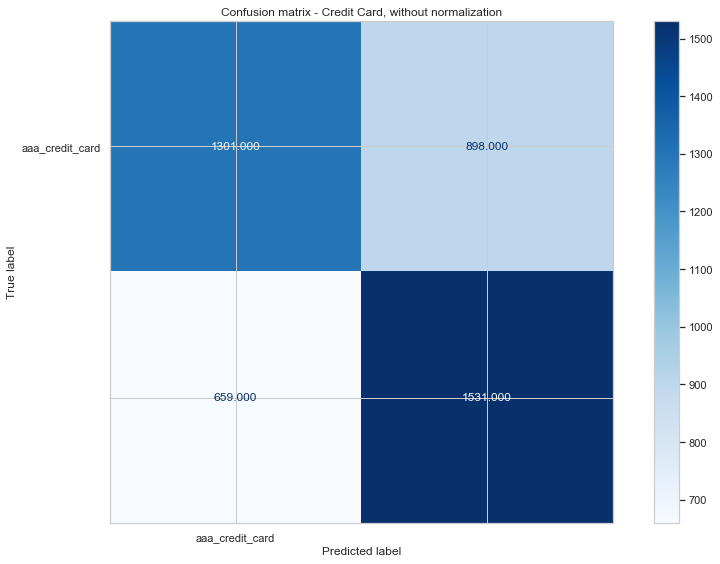

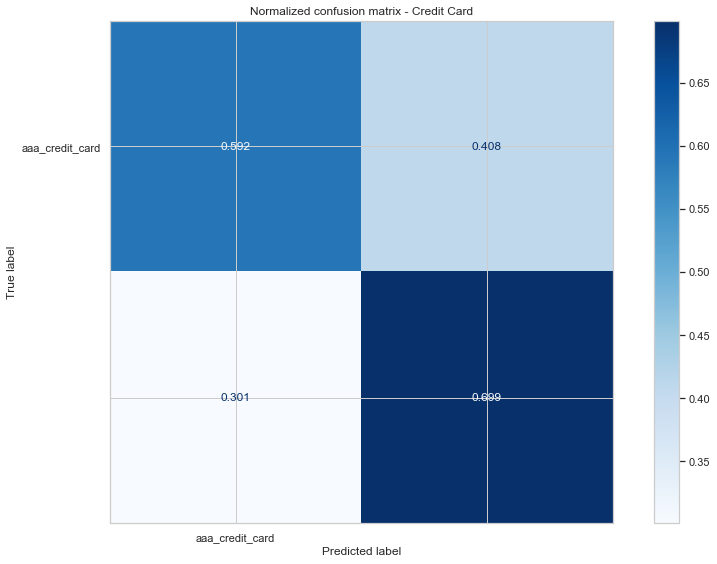

In [31]:
# Confusion Metrics
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - Credit Card, without normalization", None),
                  ("Normalized confusion matrix - Credit Card", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Binary Classifier

In [62]:
# Binary Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='log')
sgd_clf.fit(trainX, trainy)
sgd_scores = cross_val_score(sgd_clf, trainX, trainy, cv=10)
sgd_scores.mean()

array([0.5 , 0.54, 0.54, 0.5 , 0.58, 0.58, 0.54, 0.5 , 0.52, 0.46])

In [30]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': model.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts.rename(columns={"feature": "Features (no Scaling)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts, height_constant=30, index=False)
py.iplot(fig)

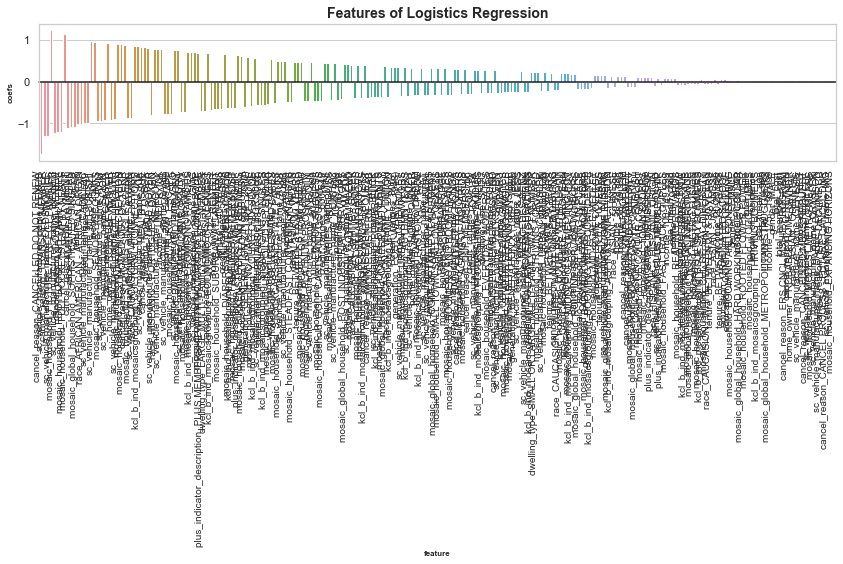

In [31]:
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=8, fontweight='bold')
plt.xlabel("Features", fontsize=8, fontweight='bold')
plt.title('Features of Logistics Regression',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(x=coef_df_lgr.feature, y=coef_df_lgr.coefs)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.show()

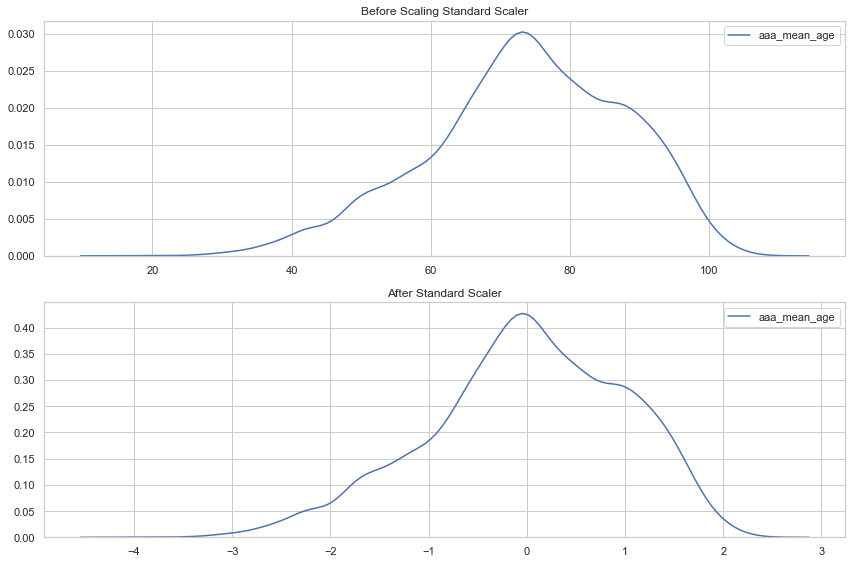

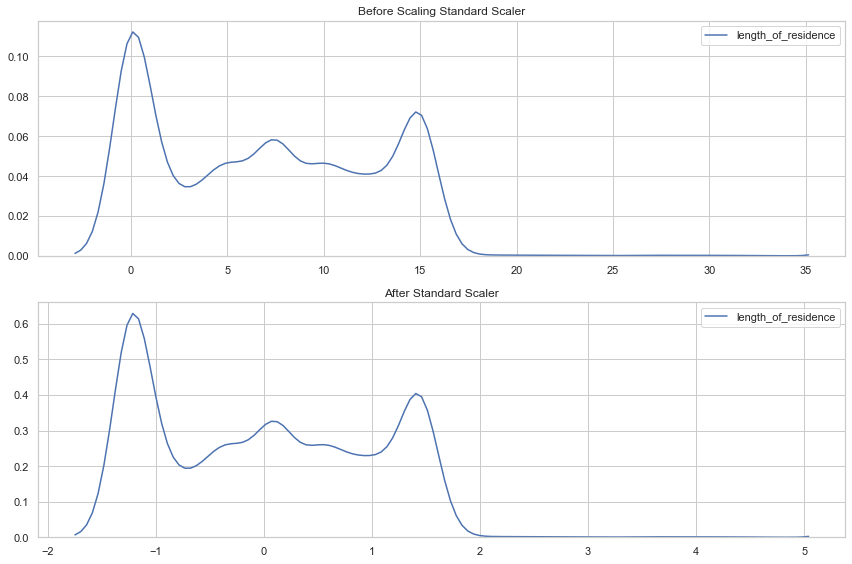

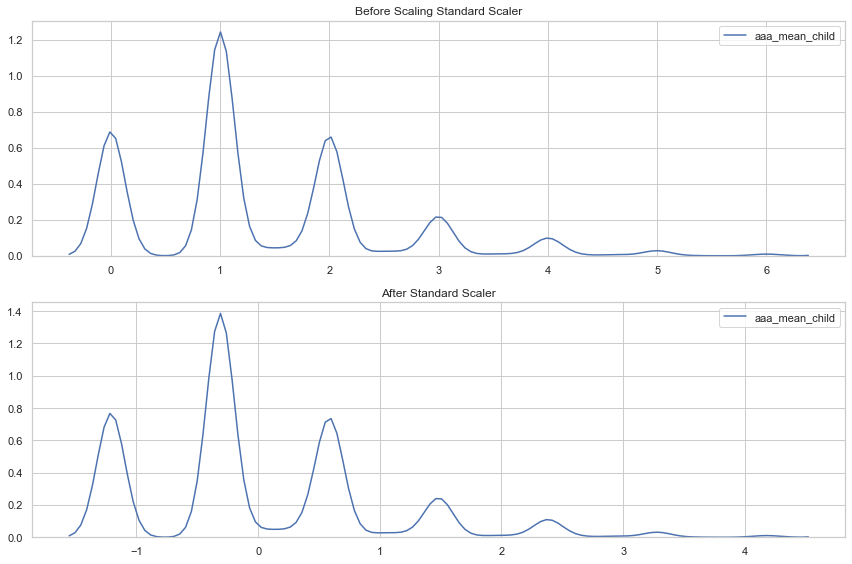

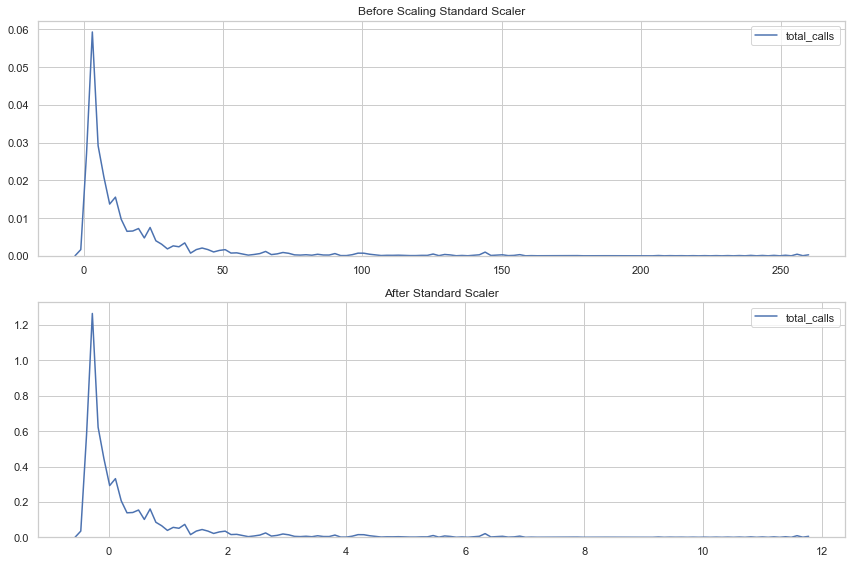

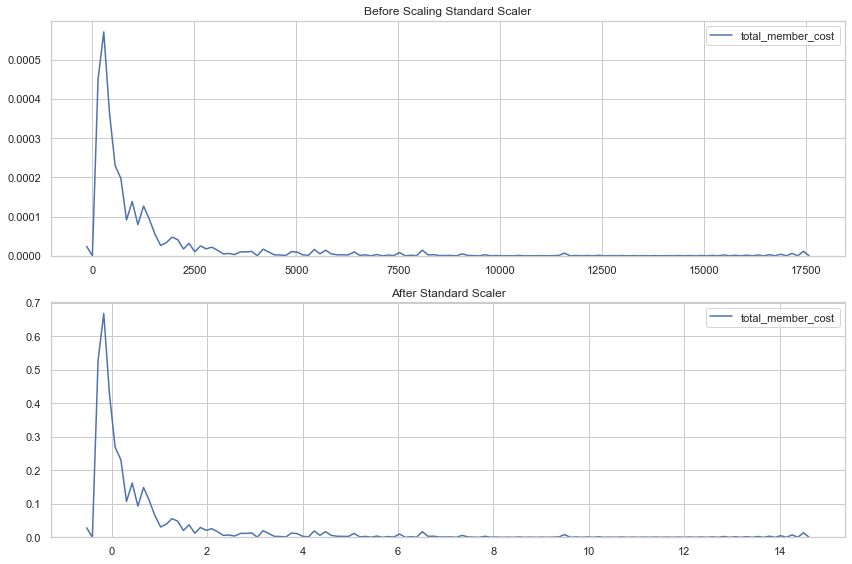

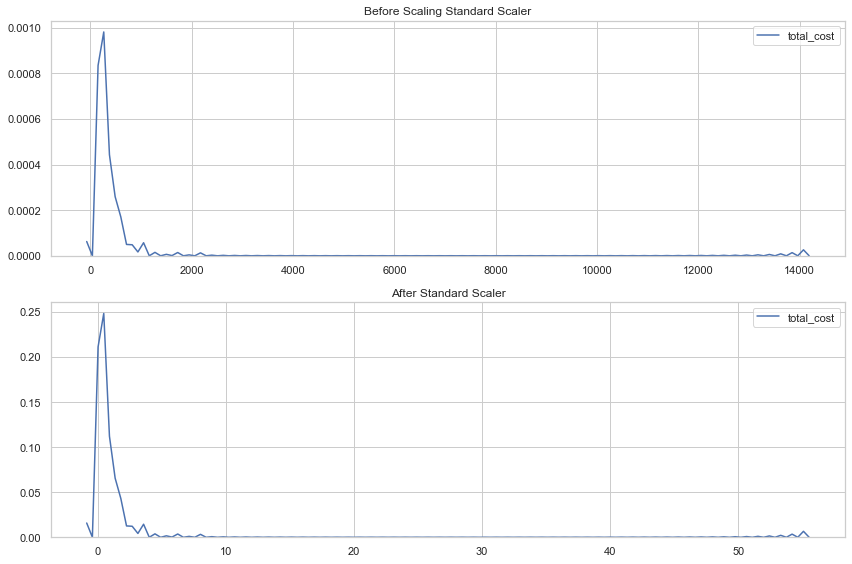

In [32]:
# Scale fields using Standard Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Standard Scaler
scaler = StandardScaler()
scaled_df_std = scaler.fit_transform(df)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=features_to_scale)


for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    ax1.set_title('Before Scaling Standard Scaler')
    ax2.set_title('After Standard Scaler')

    sns.kdeplot(df[col], ax=ax1)
    sns.kdeplot(scaled_df_std[col], ax=ax2)
    plt.show()

In [33]:
scaled_df_std.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost
count,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000
mean,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001
min,-4.0259,-1.2312,-1.2093,-0.4212,-0.4037,-0.5701
25%,-0.6050,-1.1004,-0.3113,-0.4212,-0.4037,-0.5701
50%,0.0294,0.0181,-0.3113,-0.3274,-0.3306,-0.2854
75%,0.7544,0.9105,0.5866,-0.0460,-0.0865,0.1905
max,2.3550,4.5247,4.1783,11.6304,14.4944,55.2435


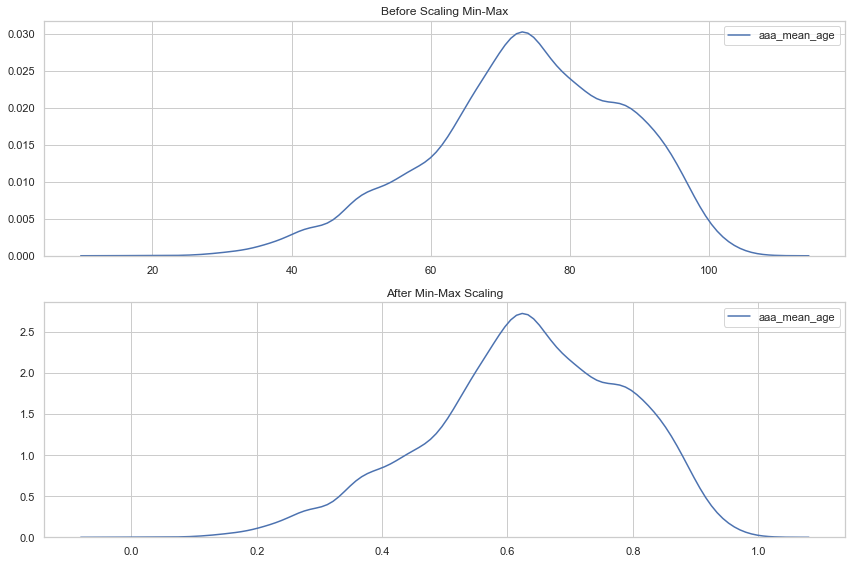

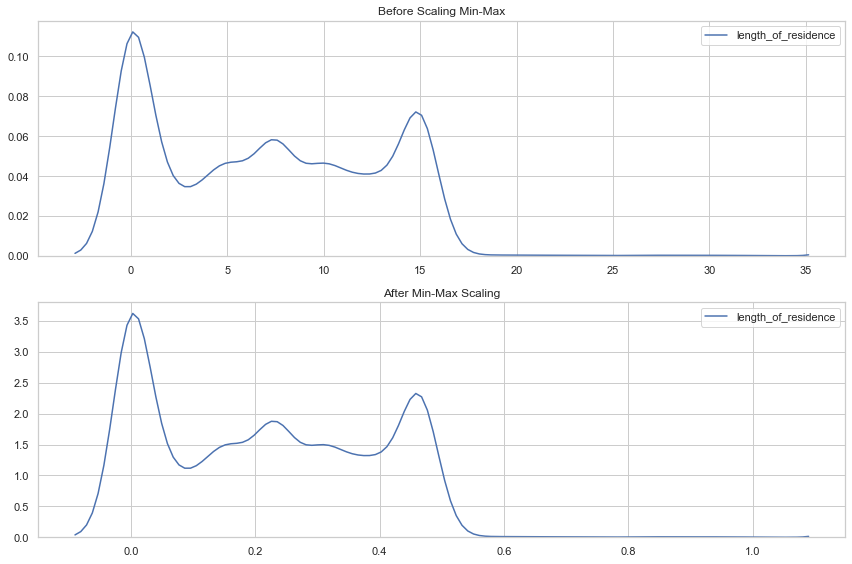

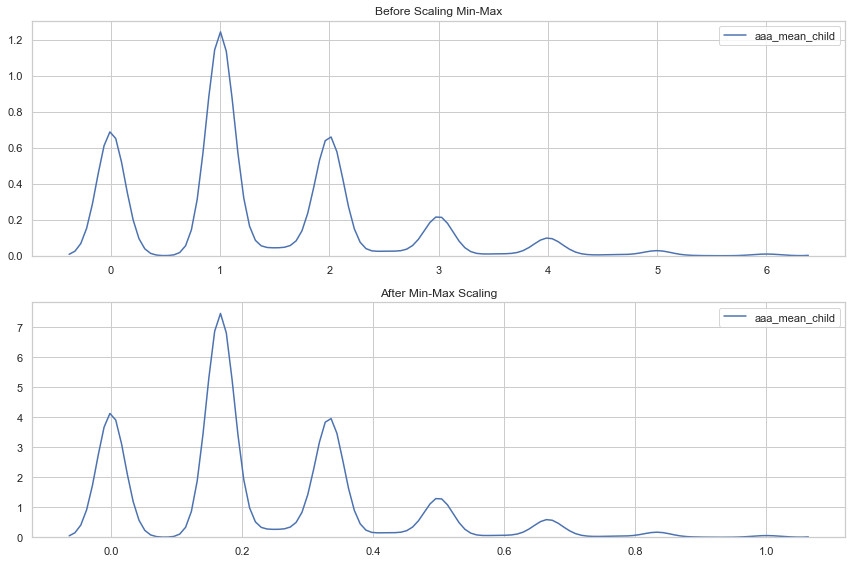

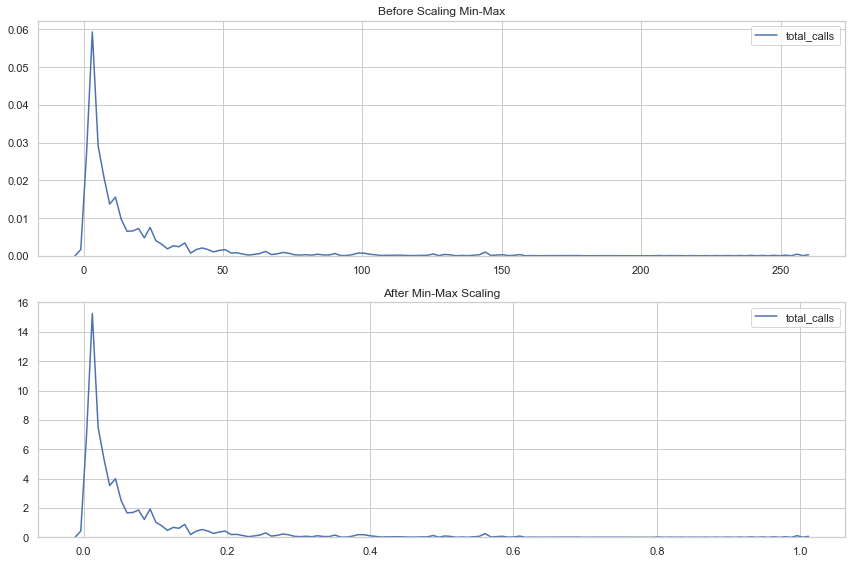

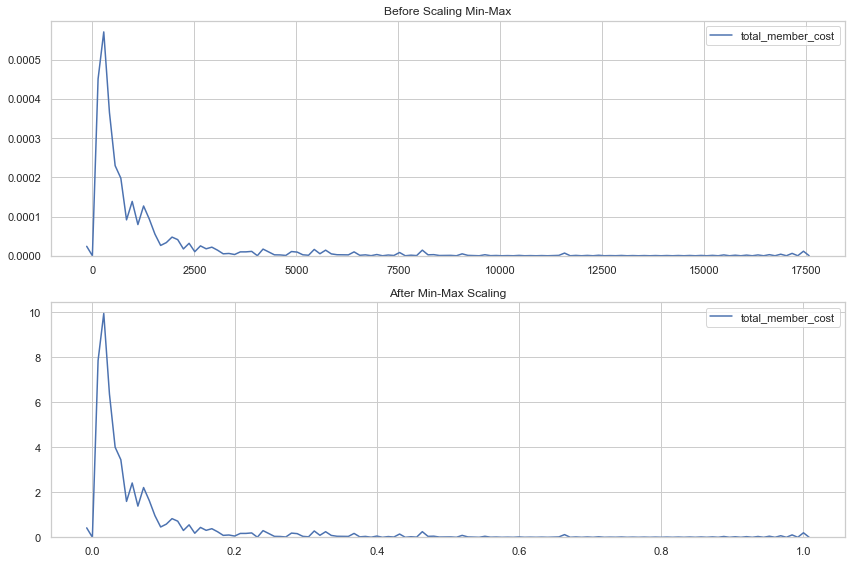

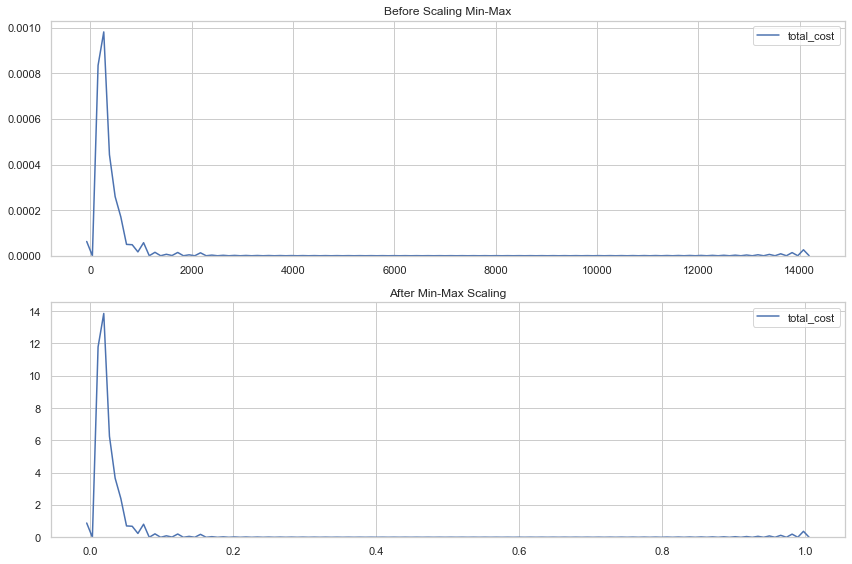

In [34]:
# Scale fields using Min-Max scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Min-Max Scaler
scaler = MinMaxScaler()
scaled_df_mm = scaler.fit_transform(df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=features_to_scale)

for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Min-Max')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Min-Max Scaling')
    sns.kdeplot(scaled_df_mm[col], ax=ax2)
    plt.show()

In [35]:
scaled_df_mm.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost
count,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000
mean,0.6309,0.2139,0.2245,0.0349,0.0271,0.0102
std,0.1567,0.1737,0.1856,0.0830,0.0671,0.0179
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.5361,0.0227,0.1667,0.0000,0.0000,0.0000
50%,0.6355,0.2171,0.1667,0.0078,0.0049,0.0051
75%,0.7492,0.3721,0.3333,0.0311,0.0213,0.0136
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


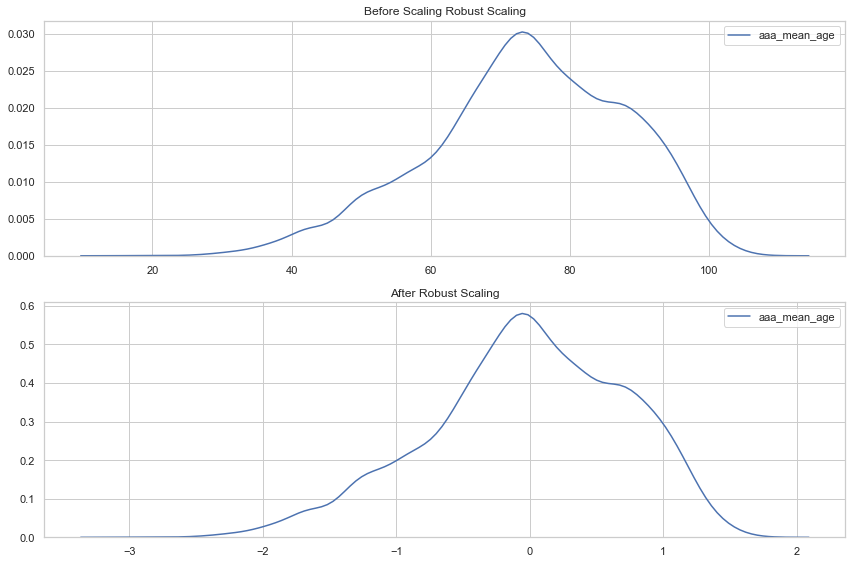

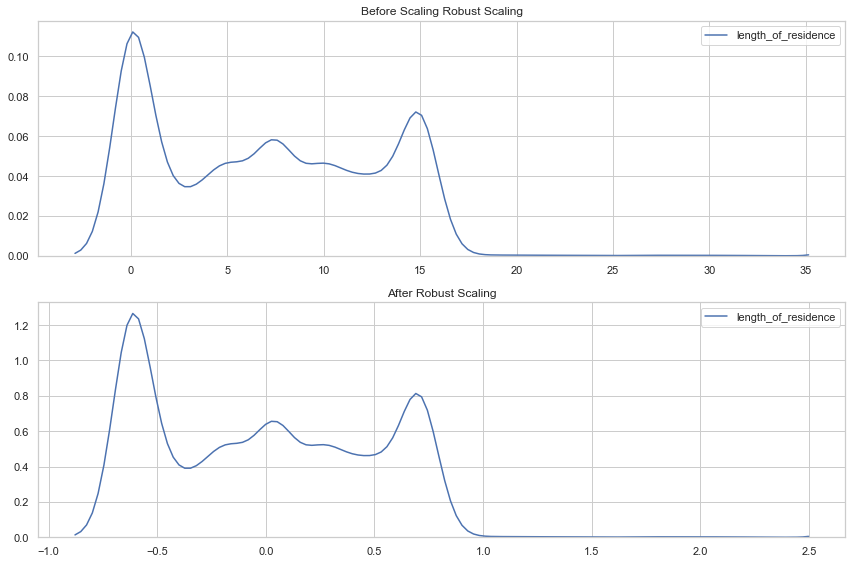

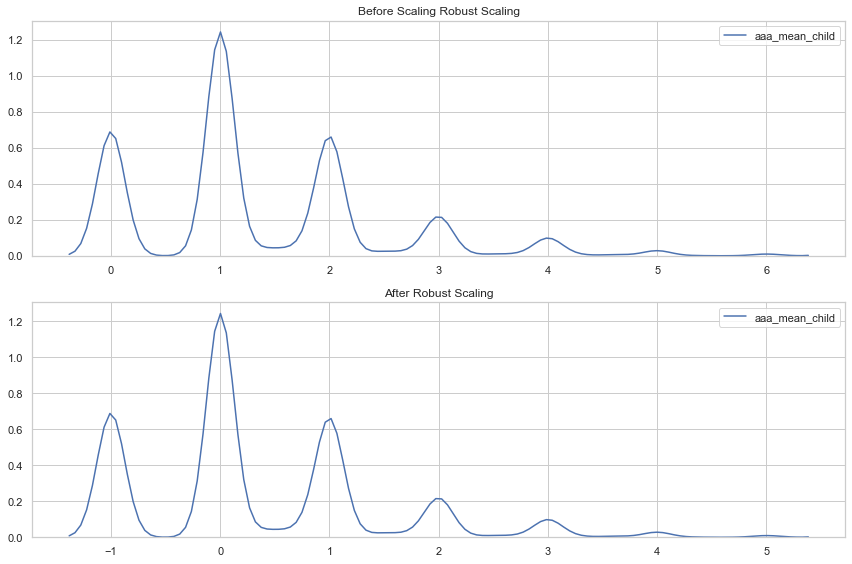

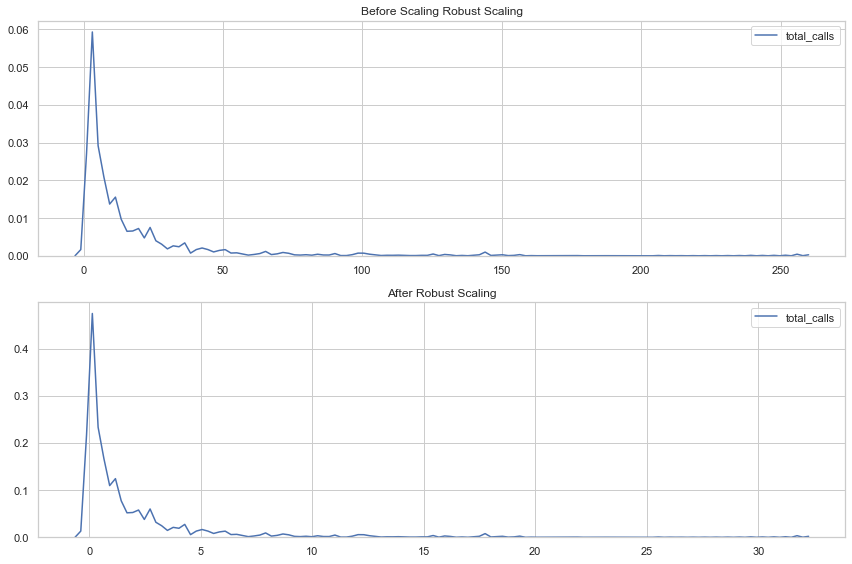

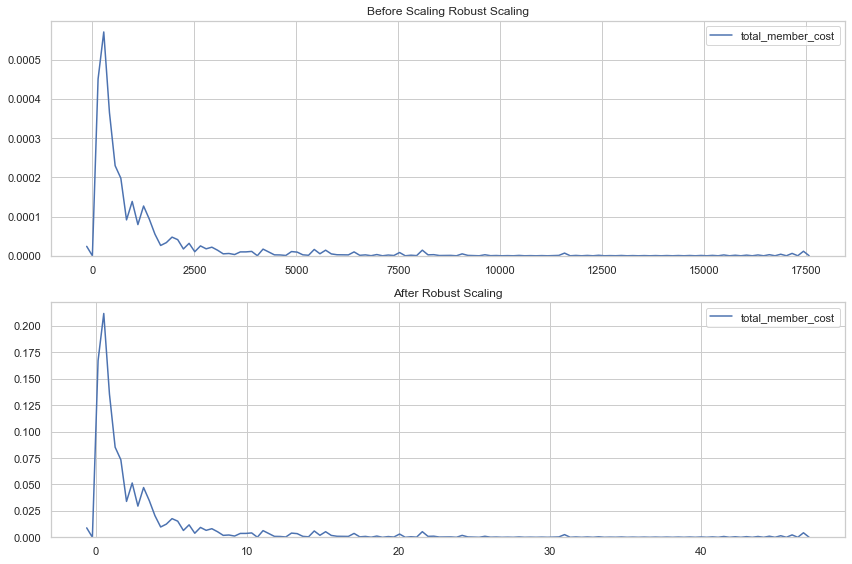

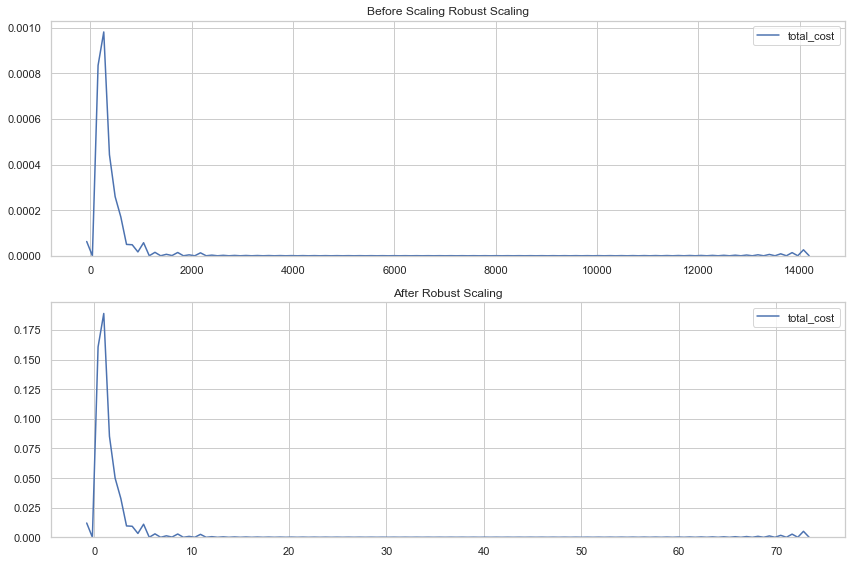

In [36]:
# Scale fields using Robust Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Robust Scaler- excellent with outliers
scaler = RobustScaler()
scaled_df_rs = scaler.fit_transform(df)
scaled_df_rs = pd.DataFrame(scaled_df_rs, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Robust Scaling')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Robust Scaling')
    sns.kdeplot(scaled_df_rs[col], ax=ax2)
    plt.show()

In [37]:
scaled_df_rs.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost
count,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000
mean,-0.0216,-0.0090,0.3467,0.8727,1.0422,0.3752
std,0.7356,0.4973,1.1137,2.6658,3.1524,1.3147
min,-2.9831,-0.6213,-1.0000,-0.2500,-0.2305,-0.3743
25%,-0.4667,-0.5562,0.0000,-0.2500,-0.2305,-0.3743
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.5333,0.4438,1.0000,0.7500,0.7695,0.6257
max,1.7107,2.2411,5.0000,31.8750,46.7321,73.0016


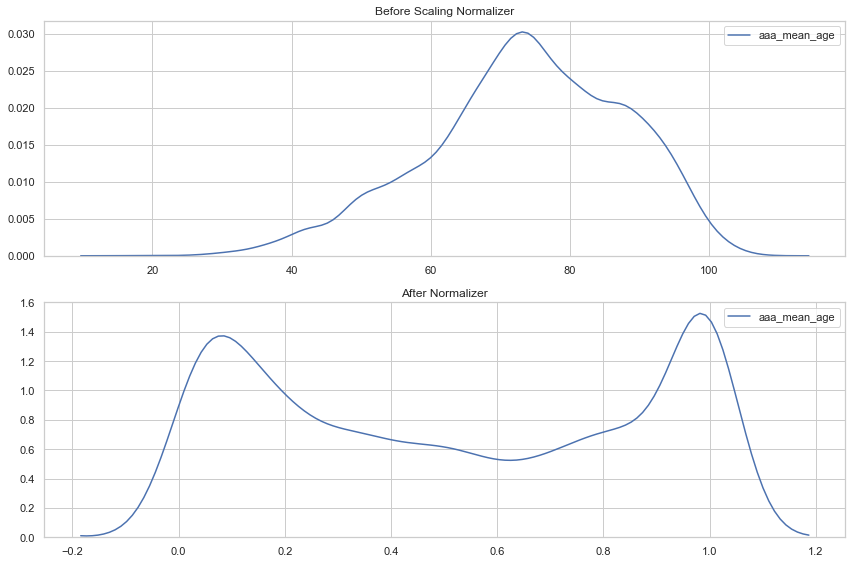

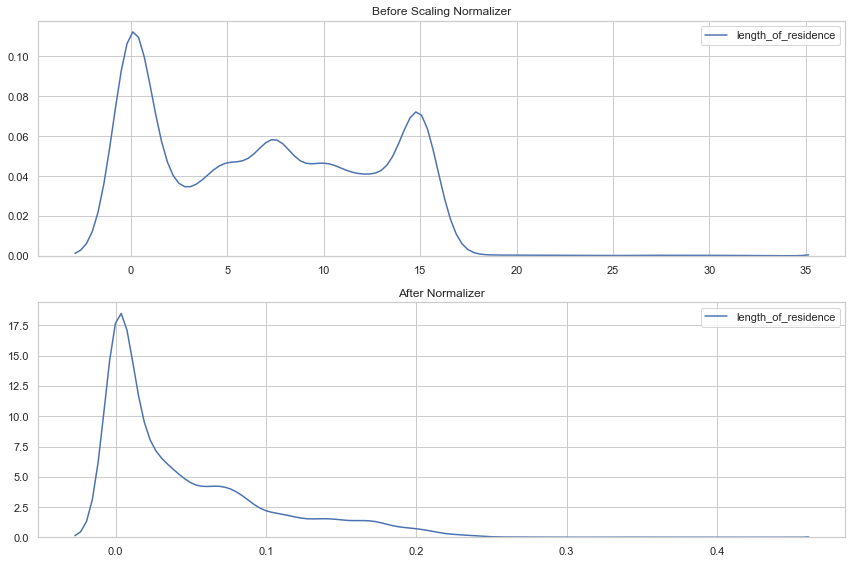

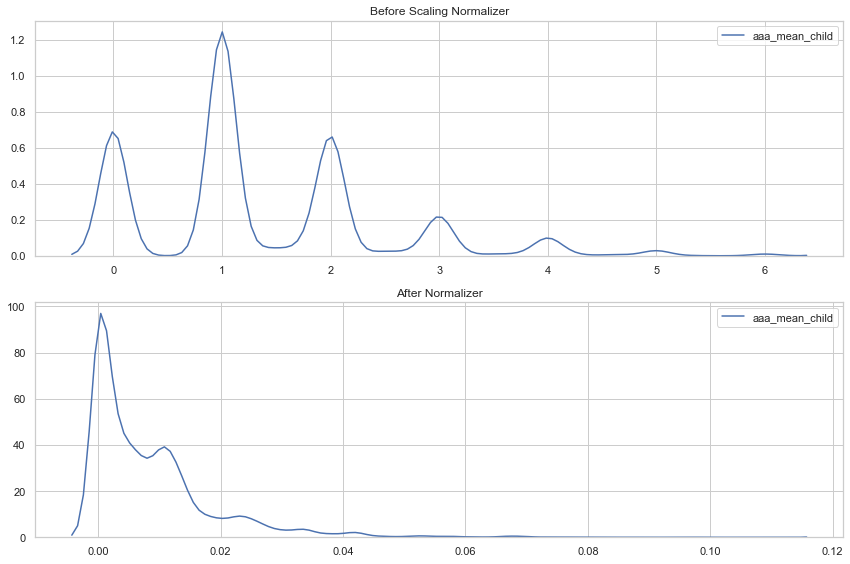

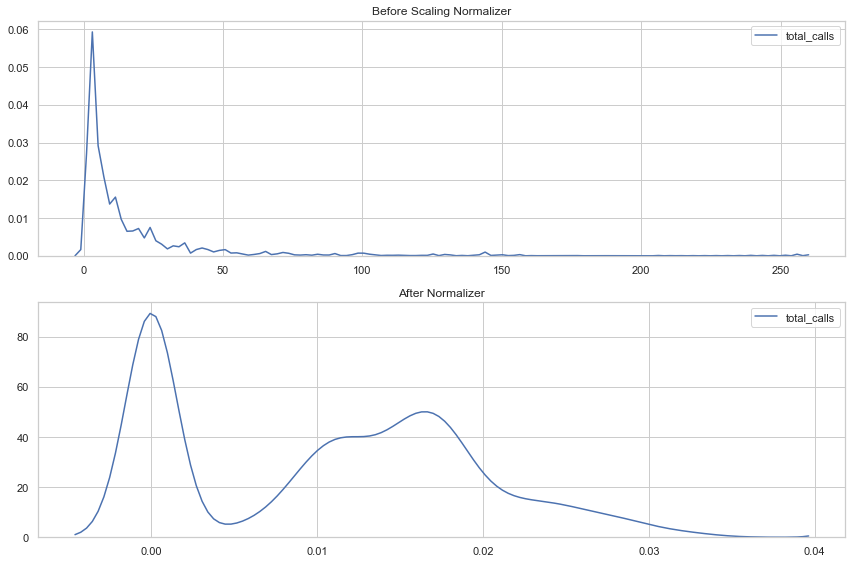

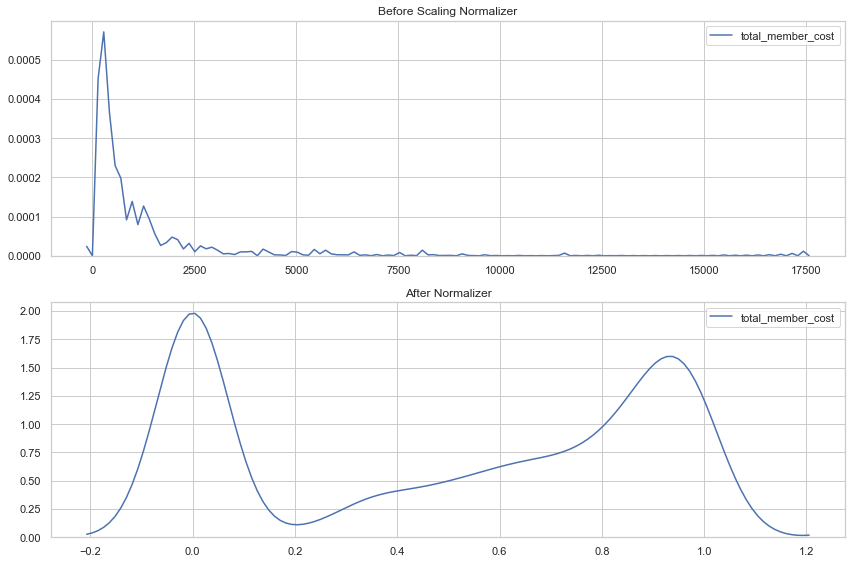

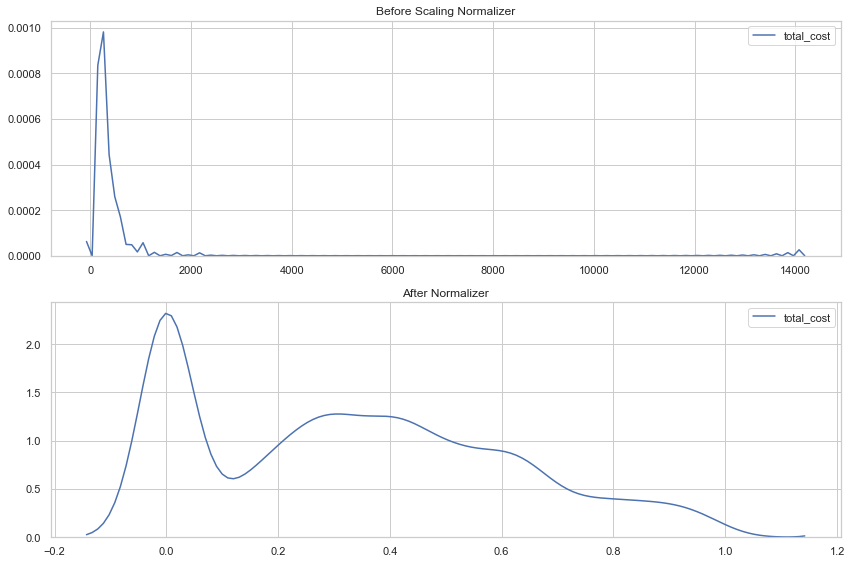

In [38]:
# Scale fields using Normalizer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Normalizer
scaler = Normalizer()
scaled_df_nm = scaler.fit_transform(df)
scaled_df_nm = pd.DataFrame(scaled_df_nm, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Normalizer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Normalizer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [39]:
scaled_df_nm.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost
count,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000
mean,0.5174,0.0450,0.0083,0.0105,0.4993,0.3314
std,0.3614,0.0553,0.0104,0.0089,0.4010,0.2763
min,0.0025,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1587,0.0007,0.0005,0.0000,0.0000,0.0000
50%,0.4943,0.0225,0.0052,0.0115,0.6026,0.3142
75%,0.8970,0.0713,0.0118,0.0172,0.8917,0.5276
max,1.0000,0.4339,0.1114,0.0350,0.9982,0.9994


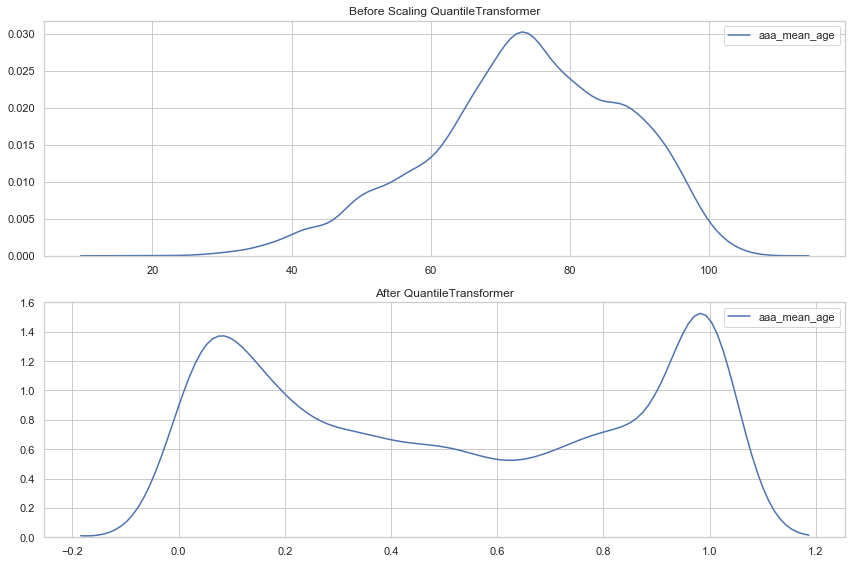

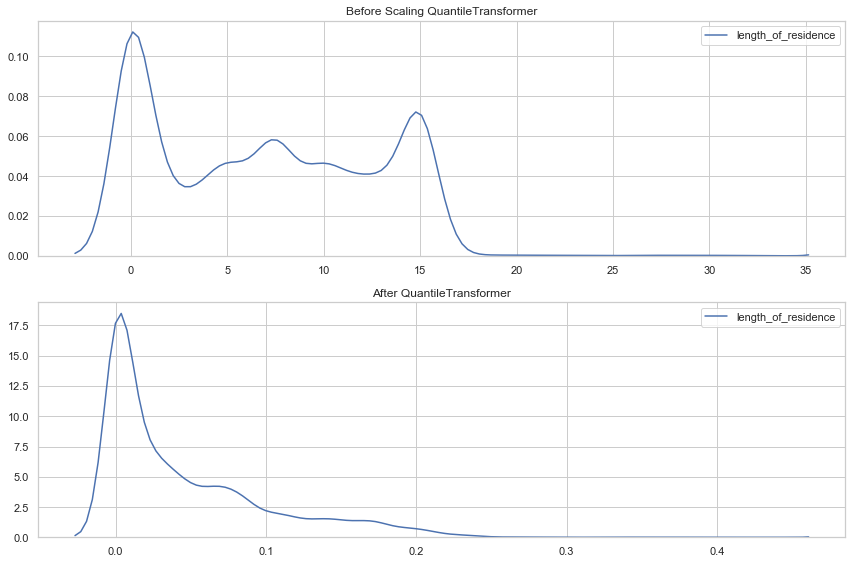

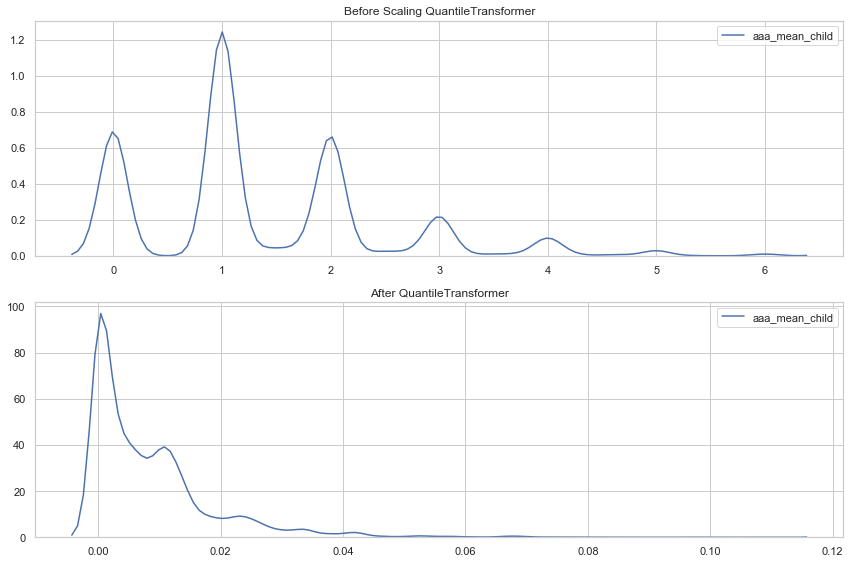

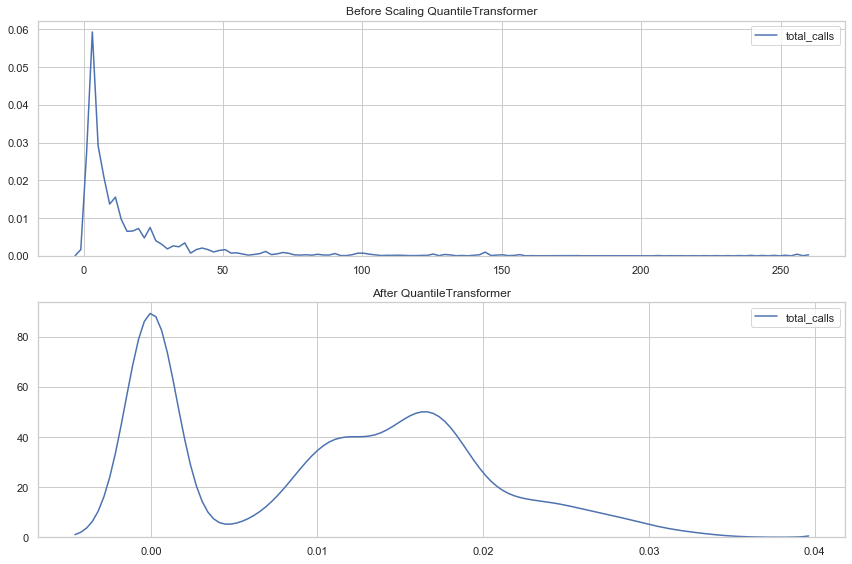

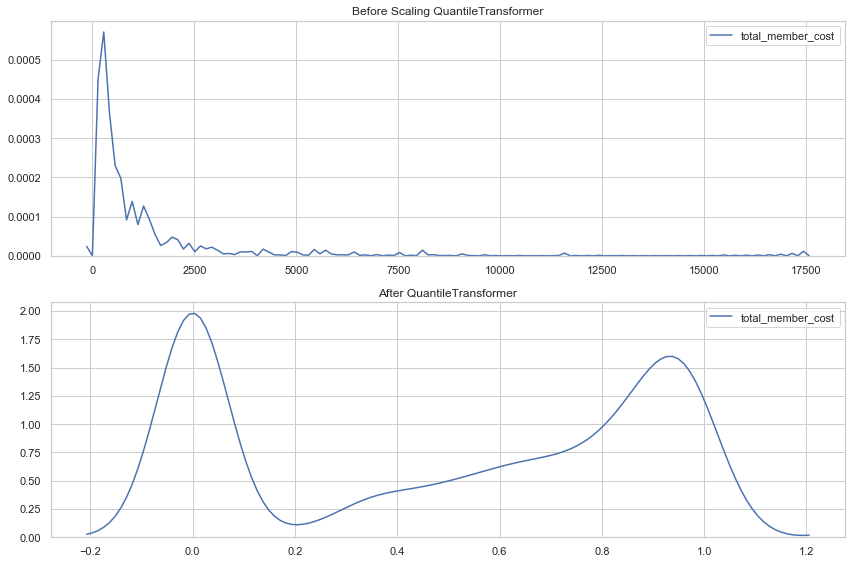

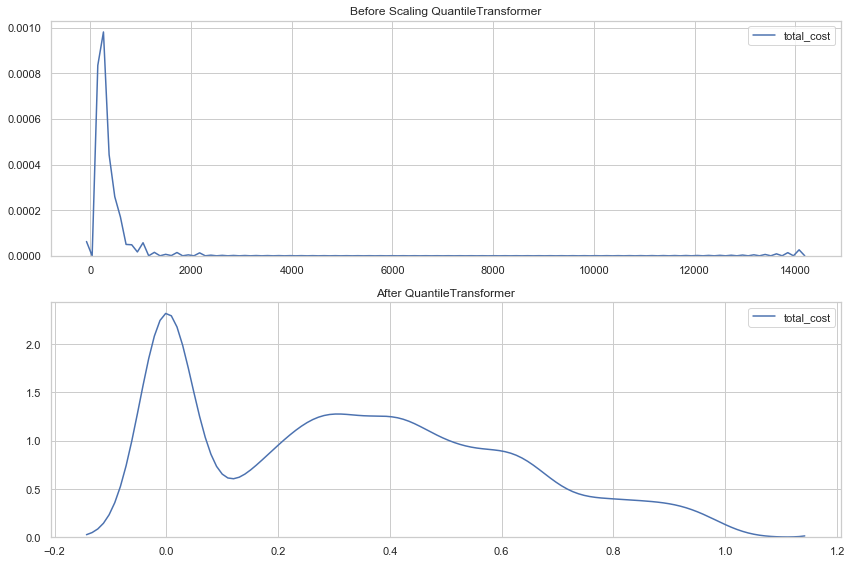

In [40]:
# Scale fields using Quantile Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# QuantileTransformer
scaler = QuantileTransformer(n_quantiles=200, output_distribution='normal')
scaled_df_qt = scaler.fit_transform(df)
scaled_df_qt = pd.DataFrame(scaled_df_qt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling QuantileTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After QuantileTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [41]:
scaled_df_qt.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost
count,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000
mean,-0.0002,-0.9269,-0.8512,-1.4280,-1.4316,-1.0953
std,0.9967,2.4450,2.4165,2.7977,2.7925,2.5956
min,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993
25%,-0.6705,-0.6717,-0.2029,-5.1993,-5.1993,-5.1993
50%,-0.0013,-0.0063,-0.2029,0.0567,0.0016,-0.0035
75%,0.6772,0.6944,0.6944,0.6864,0.6705,0.6717
max,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993


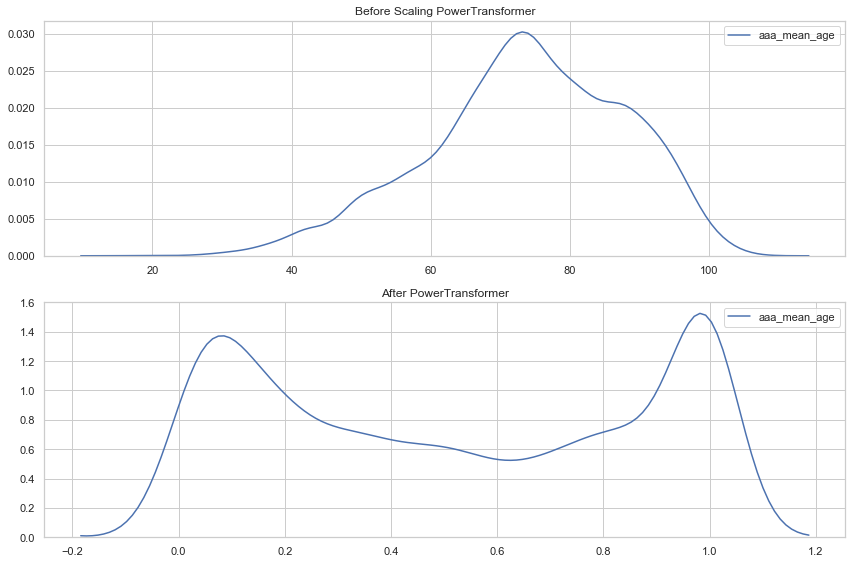

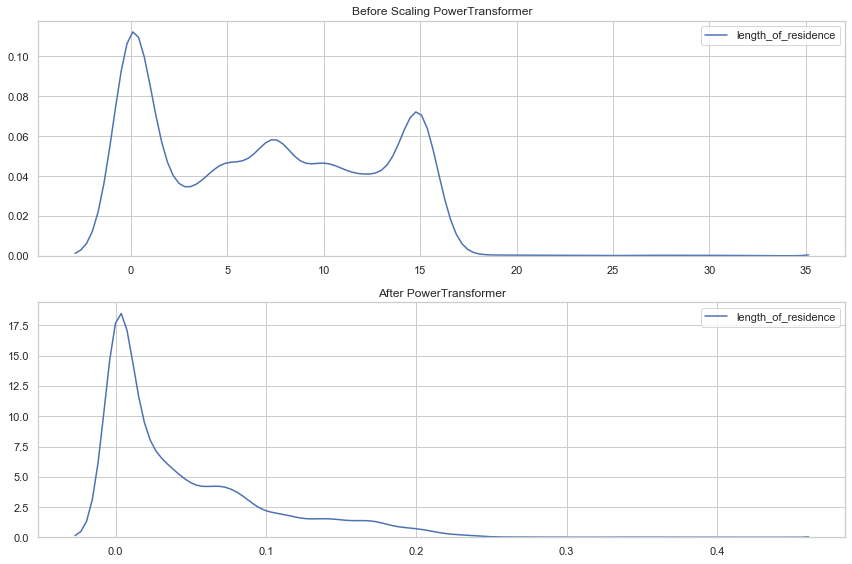

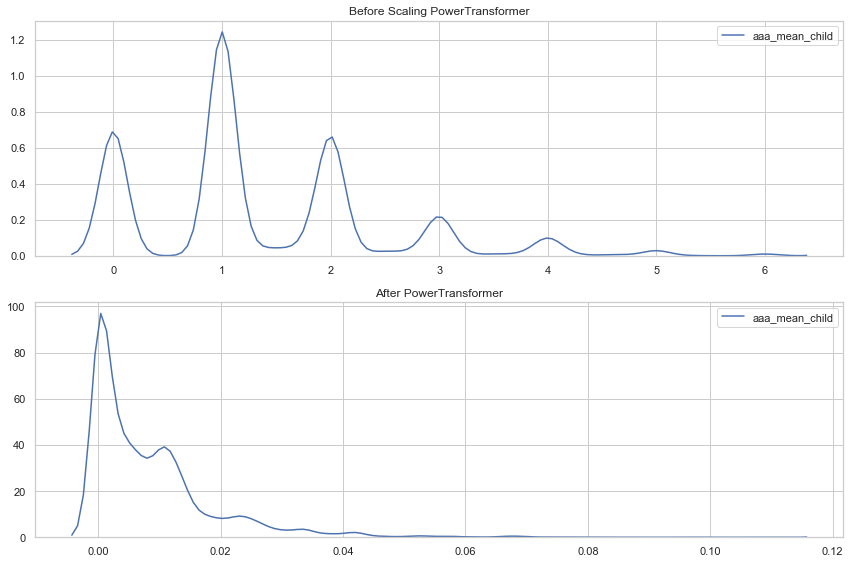

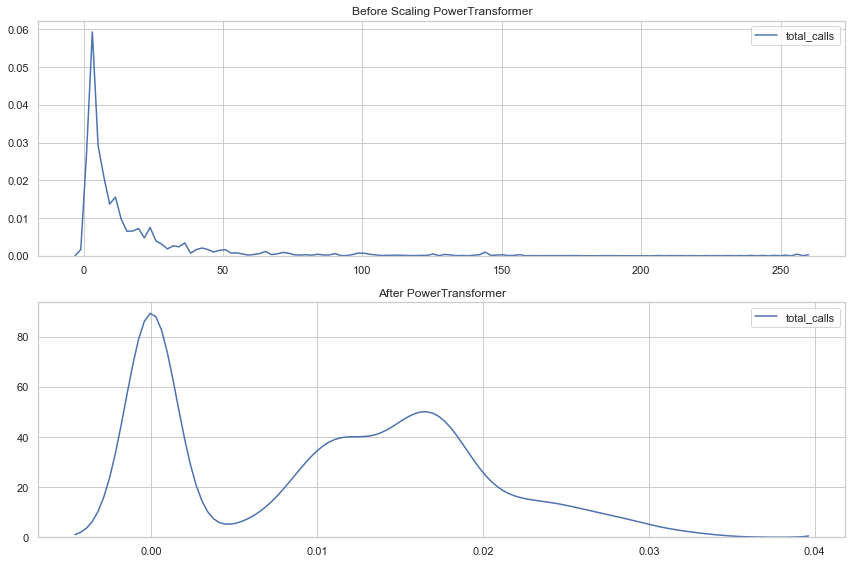

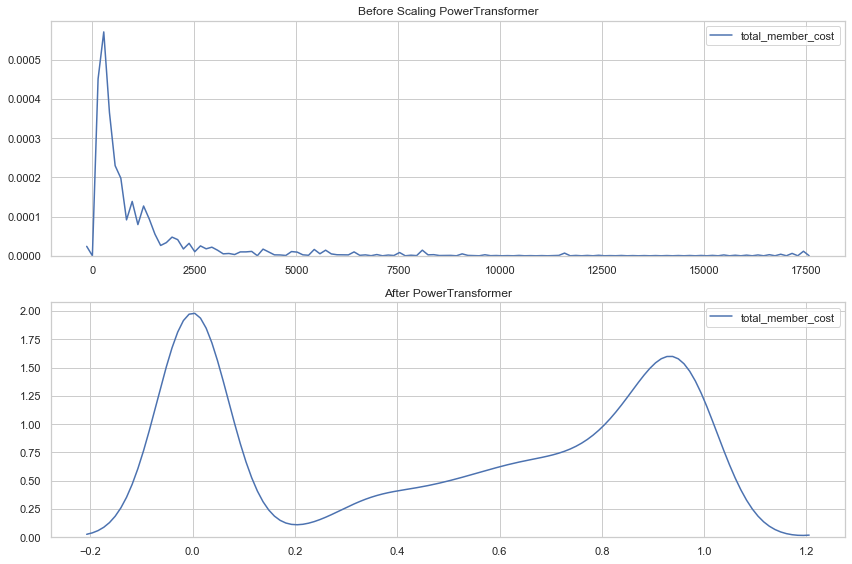

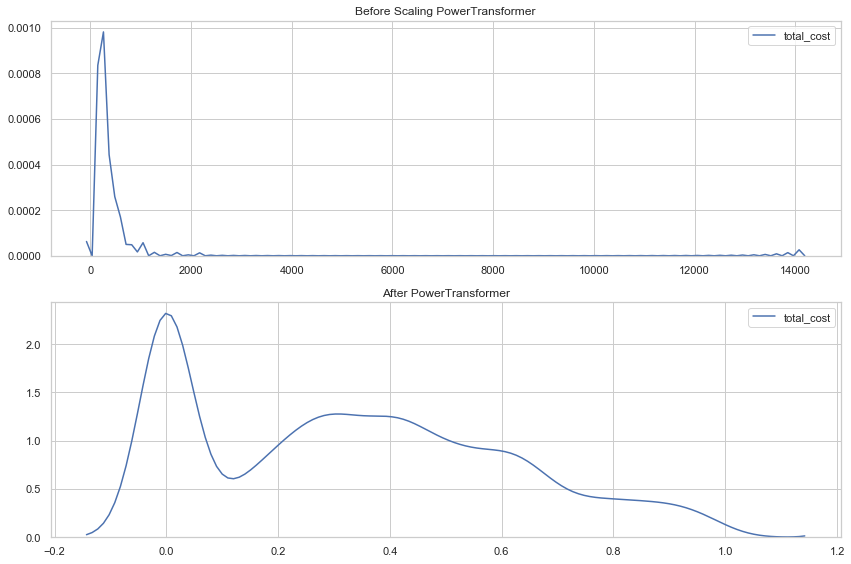

In [42]:
# Scale fields using Power Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# PowerTransformer
scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
scaled_df_pt = scaler.fit_transform(df)
scaled_df_pt = pd.DataFrame(scaled_df_pt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling PowerTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After PowerTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [43]:
scaled_df_pt.describe()

,aaa_mean_age,length_of_residence,aaa_mean_child,total_calls,total_member_cost,total_cost
count,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000,8778.0000
mean,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001
min,-3.0079,-1.4155,-1.5045,-1.1473,-1.2418,-1.4182
25%,-0.6628,-1.1180,-0.1337,-1.1473,-1.2418,-1.4182
50%,-0.0363,0.2410,-0.1337,0.0682,0.2244,0.1484
75%,0.7442,0.9140,0.7309,0.8887,0.7717,0.7352
max,2.6989,2.7308,2.7006,2.0799,2.4005,5.2571


Accuracy (Normalizer Transformer)                  : 0.654
Precision (Normalizer Transformer)                 : 0.635
Recall (Normalizer Transformer)                    : 0.721
F-measure (Normalizer Transformer)                 : 0.675
Log-Loss (Normalizer Transformer)                  : 11.954
No Skill - ROC AUC (Normalizer Transformer)        : 0.500
Logistic - ROC AUC (Normalizer Transformer)        : 0.699
Cross Validation Accuracy (Normalizer Transformer) : 0.64 (+/- 0.03)


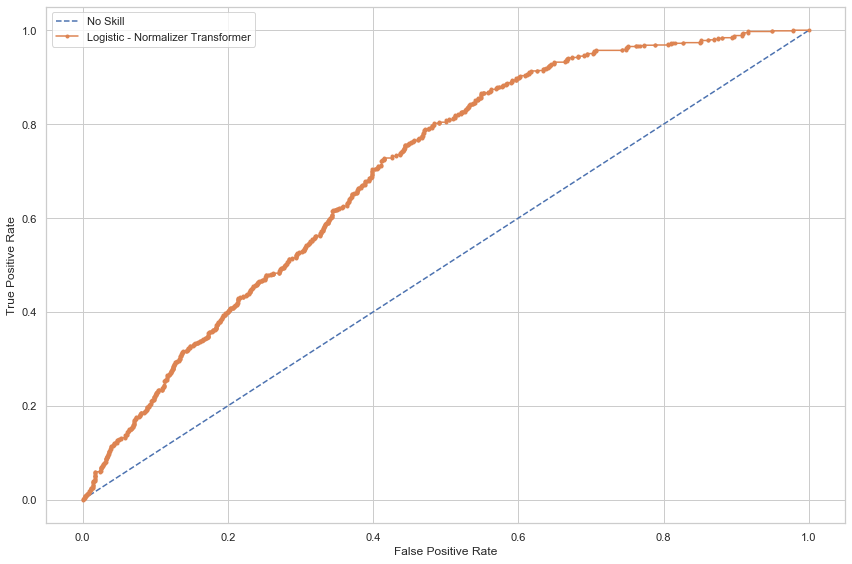

In [44]:
# As there is only 11 memebrs that are using the mortgage service..
# Will upsample the 11 (yes) to 5229
# Evaluate imbalanced classification model with different metrics
np.random.seed(42)
features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
                     
df_new = df_test_over.copy()

# Going to use the Normalizer Scaler as it is giving a range between 0-1
df_new[features_to_scale] = scaled_df_nm[features_to_scale]

X_df = pd.DataFrame(df_new,columns=X_cols)
y_df = pd.DataFrame(df_new,columns=y_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(X_df, y_df, test_size=0.50)

# Define model 
model = LogisticRegression(solver='liblinear')

# Fit model
model.fit(trainX, trainy)

# Predict on test set
yhat = model.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = model.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
scores = cross_val_score(model, testX, testy, cv=10)

# Evaluate predictions
print('Accuracy (Normalizer Transformer)                  : %.3f' % accuracy_score(testy, yhat))
print('Precision (Normalizer Transformer)                 : %.3f' % precision_score(testy, yhat))
print('Recall (Normalizer Transformer)                    : %.3f' % recall_score(testy, yhat))
print('F-measure (Normalizer Transformer)                 : %.3f' % f1_score(testy, yhat))
print('Log-Loss (Normalizer Transformer)                  : %.3f' % log_loss(testy, yhat))
print('No Skill - ROC AUC (Normalizer Transformer)        : %.3f' % (ns_auc))
print('Logistic - ROC AUC (Normalizer Transformer)        : %.3f' % (lr_auc))
print("Cross Validation Accuracy (Normalizer Transformer) : %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - Normalizer Transformer')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Confusion matrix, without normalization
[[2432  111]
 [   0 2409]]
Normalized confusion matrix
[[0.96 0.04]
 [0.   1.  ]]


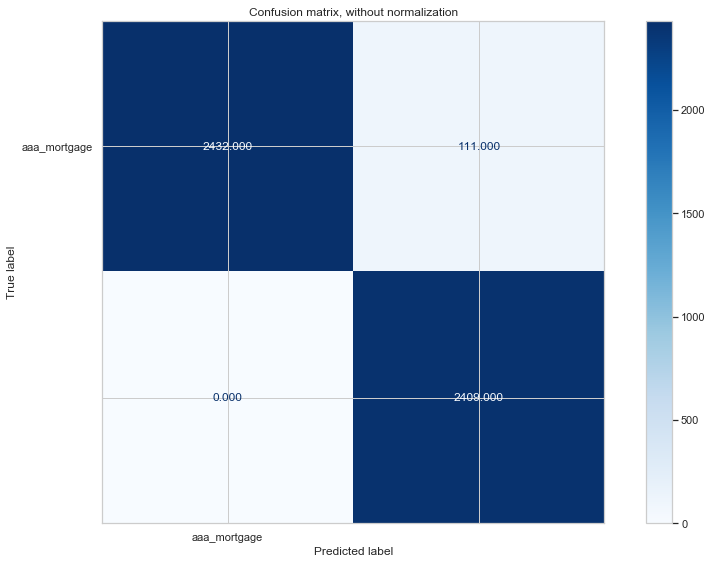

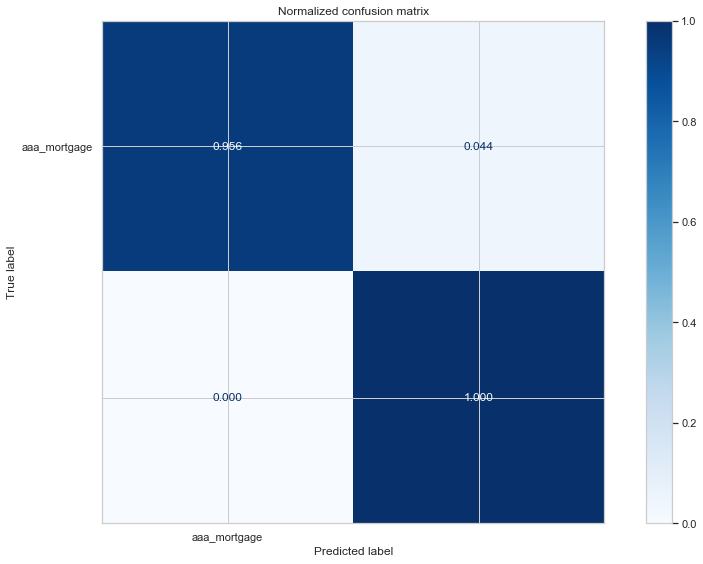

In [38]:
# Confusion Metrics
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [39]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': model.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts.rename(columns={"feature": "Features (Normalizer Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts, height_constant=30, index=False)
py.iplot(fig)

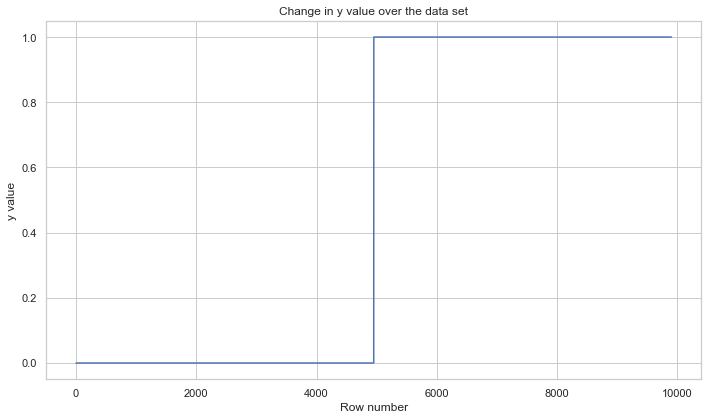

In [42]:
plt.figure(figsize=(10,6))
plt.plot(df_test_over['aaa_mortgage'].values)
plt.xlabel('Row number')
plt.ylabel('y value')
plt.title('Change in y value over the data set')
plt.show();